# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "./data/network-traffic-volume-2019-07-01.csv"

history = 24  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'LSTM_FCN'
# Save the results
y_true_fn = '%s_true-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred-%d-%d.pkl' % (model_name, history, horizon)

In [10]:
y_true_fn

'LSTM_FCN_true-24-1.pkl'

In [11]:
y_pred_fn

'LSTM_FCN_pred-24-1.pkl'

# Load Data

In [12]:
df = pd.read_csv(file_name, sep=';')

In [13]:
start = datetime(1970, 1, 1)  # Unix epoch start time
df['datetime'] = df.clock.apply(lambda x: start + timedelta(seconds=x))

In [14]:
df.head()

itemid       clock  num  value_min  value_avg  value_max  \
0  159138  1563192000   60  170651112  222446310  245355432   
1  159138  1563188400   60   92258968  156333926  245517360   
2  159138  1563184800   60   29854256   73581269  121096792   
3  159138  1563181200   60     333720   12801917   43525128   
4  159138  1563177600   60     183976    1146488   11797152   

             datetime  
0 2019-07-15 12:00:00  
1 2019-07-15 11:00:00  
2 2019-07-15 10:00:00  
3 2019-07-15 09:00:00  
4 2019-07-15 08:00:00

Reverse the data order:

In [15]:
df = df.reindex(index=df.index[::-1])
df = df.reset_index(drop=True)

In [16]:
df.head()

itemid       clock  num  value_min  value_avg  value_max  \
0  159138  1547647200   60  176234272  218584709  282860160   
1  159138  1547650800   60  175043128  239018429  302135312   
2  159138  1547654400   60  192060848  247729961  455722696   
3  159138  1547658000   60  185162976  222326142  268226440   
4  159138  1547661600   60  169504880  220546435  306695032   

             datetime  
0 2019-01-16 14:00:00  
1 2019-01-16 15:00:00  
2 2019-01-16 16:00:00  
3 2019-01-16 17:00:00  
4 2019-01-16 18:00:00

In [17]:
# add a datetimeindex
dates = pd.DatetimeIndex(df['datetime'])
df = df.set_index(dates).asfreq('H')  # one hour as the original sampling time frequency

In [18]:
df.head()

itemid       clock  num  value_min  value_avg  value_max  \
datetime                                                                        
2019-01-16 14:00:00  159138  1547647200   60  176234272  218584709  282860160   
2019-01-16 15:00:00  159138  1547650800   60  175043128  239018429  302135312   
2019-01-16 16:00:00  159138  1547654400   60  192060848  247729961  455722696   
2019-01-16 17:00:00  159138  1547658000   60  185162976  222326142  268226440   
2019-01-16 18:00:00  159138  1547661600   60  169504880  220546435  306695032   

                               datetime  
datetime                                 
2019-01-16 14:00:00 2019-01-16 14:00:00  
2019-01-16 15:00:00 2019-01-16 15:00:00  
2019-01-16 16:00:00 2019-01-16 16:00:00  
2019-01-16 17:00:00 2019-01-16 17:00:00  
2019-01-16 18:00:00 2019-01-16 18:00:00

# Split the data

In [19]:
train = df[df['datetime'] < '2019-06-16 00:00:00']
test = df[df['datetime'] > '2019-06-16 00:00:00']
train_length = train.shape[0]
test_length = test.shape[0]

In [20]:
print('Training size: ', train_length)
print('Test size: ', test_length)

Training size:  3610
Test size:  708


In [21]:
print('Test ratio: ', test_length / (test_length + train_length))

Test ratio:  0.16396479851783233


We plot the different time periods data:

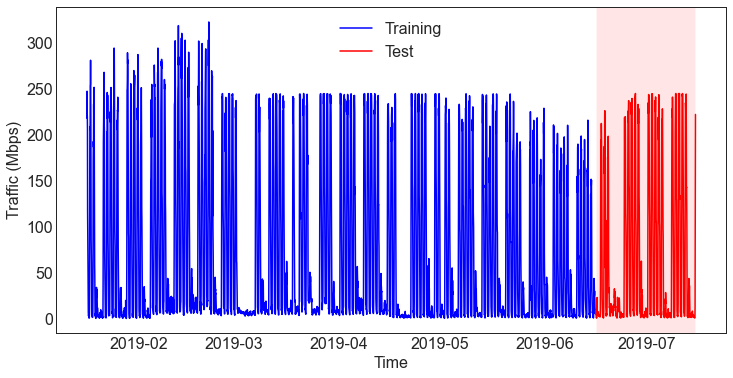

In [22]:
plt.figure(figsize=[12, 6])
plt.plot(df.index[:train_length], df['value_avg'][:train_length] / 1000 / 1000, label='Training', color='blue')
plt.plot(df.index[train_length:], df['value_avg'][train_length:] / 1000 / 1000, label='Test', color='red')
plt.axvspan(df.index[train_length:][0], df.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

# Normalize the data

Define the input features and the target column:

In [23]:
input_features = ['value_avg', 'value_min', 'value_max']

In [24]:
data = df[input_features].values

Calculate the min and max data based on the training data set:

In [25]:
max_list = np.max(data[:train_length], axis=0)

In [26]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [27]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [28]:
print(np.max(data[:train_length].flatten()))

1.0


In [29]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [30]:
print(np.max(data.flatten()))

1.0


In [31]:
print(np.min(data.flatten()))

0.0


# Build the supervised prediction problem

The input data is in the following format:

* x_data as input features: [data size, input channels, input historical steps]. Here the input channel number is the input feature numbers. For univariate time series case, the input channel is 1 (value_avg). For multivariate time series case, the input channel is 3 (value_avg, value_max, value_min).
* y_data as output targets: [data size, output prediction steps].

In [32]:
length = data.shape[0]
print(length)

4319


In [33]:
x_data = []
y_data = []
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, 0]  # output predicted time steps, we only predict value_avg
    x_data.append(x)
    y_data.append(y)

In [34]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [35]:
x_data.shape

(4295, 24, 3)

In [36]:
y_data.shape

(4295, 1)

Reshape x_data:

In [37]:
x_data = np.swapaxes(x_data, 1, 2)

In [38]:
x_data.shape

(4295, 3, 24)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [39]:
test_length = test_length - horizon + 1

In [40]:
train_valid_length = x_data.shape[0] - test_length

In [41]:
train_valid_length

3587

We further split a valid data set for hyper parameter tuning:

In [42]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [43]:
train_length

2869

In [44]:
valid_length

718

In [45]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [46]:
X_train.shape

(2869, 3, 24)

In [47]:
y_train.shape

(2869, 1)

In [48]:
X_valid.shape

(718, 3, 24)

In [49]:
y_valid.shape

(718, 1)

In [50]:
X_test.shape

(708, 3, 24)

In [51]:
y_test.shape

(708, 1)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [52]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [53]:
splits

((#2869) [0,1,2,3,4,5,6,7,8,9...],
 (#718) [2869,2870,2871,2872,2873,2874,2875,2876,2877,2878...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [54]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [55]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "rnn_layers": hp.choice('rnn_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False]),
    "rnn_dropout": hp.choice('rnn_dropout', [0.3, 0.5, 0.8]),
    "conv_layers": hp.choice('conv_layers', [[128, 256, 128], [64, 128, 64], [256, 512, 256]]),
    "kss": hp.choice('kss', [[7, 5, 3], [5, 5, 3], [3, 3, 3]]),
    "fc_dropout": hp.choice('fc_dropout', [0.0, 0.3, 0.5])
}

In [56]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x17f2e6e1988>,
 'lr': <hyperopt.pyll.base.Apply at 0x17f2eded1c8>,
 'epochs': <hyperopt.pyll.base.Apply at 0x17f2e6e1d88>,
 'patience': <hyperopt.pyll.base.Apply at 0x17f2ee00248>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x17f2ee00608>,
 'rnn_layers': <hyperopt.pyll.base.Apply at 0x17f2ee00c88>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x17f2e6e4248>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x17f2e6e47c8>,
 'rnn_dropout': <hyperopt.pyll.base.Apply at 0x17f2e6e4dc8>,
 'conv_layers': <hyperopt.pyll.base.Apply at 0x17f2e6d0bc8>,
 'kss': <hyperopt.pyll.base.Apply at 0x17f2e6d5908>,
 'fc_dropout': <hyperopt.pyll.base.Apply at 0x17f2e6d5e88>}

In [57]:
# clear memory 
gc.collect()

2955

In [58]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = LSTM_FCN
        k = {
            'rnn_layers': params['rnn_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional'],
            'rnn_dropout': params['rnn_dropout'],
            'conv_layers': params['conv_layers'],
            'kss': params['kss'],
            'fc_dropout': params['fc_dropout']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
  0%|                                                                          | 0/100 [00:04<?, ?trial/s, best loss=?]

No improvement since epoch 20: early stopping                                                                          
  0%|                                                                          | 0/100 [00:34<?, ?trial/s, best loss=?]

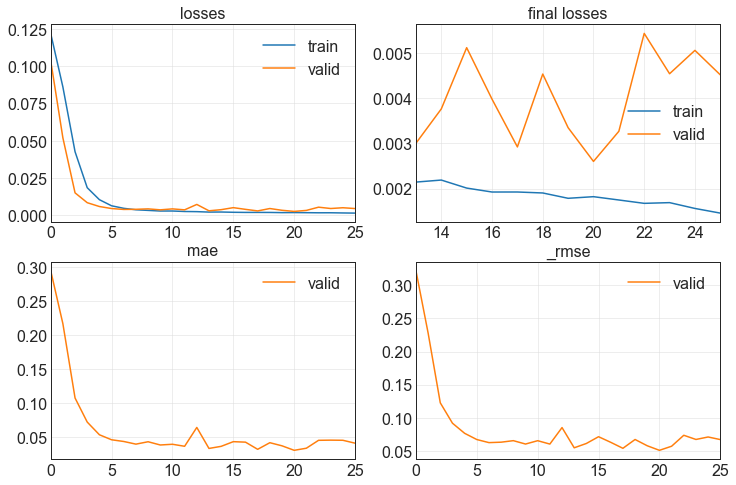

30.92832589149475                                                                                                      
[0.00145872647408396, 0.00451596500352025, 0.041207205504179, 0.0672009289264679]                                      
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 100, 'fc_dropout': 0.5, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
  1%|▍                                              | 1/100 [00:35<57:53, 35.09s/trial, best loss: 0.00451596500352025]

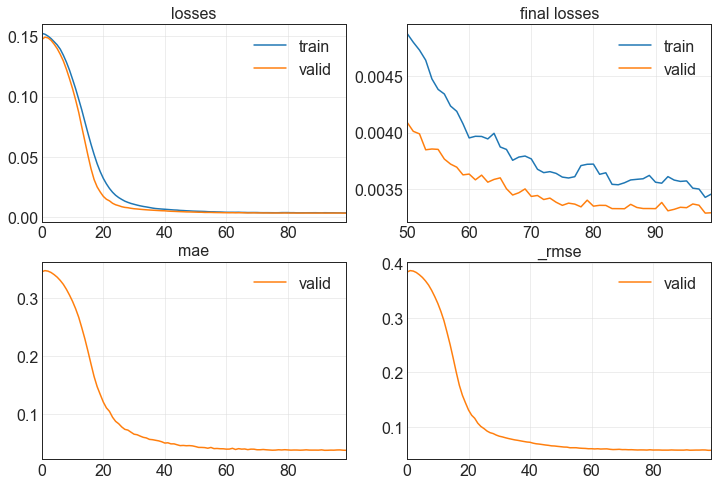

25.417677402496338                                                                                                     
[0.003457325976341963, 0.003291516564786434, 0.03772469982504845, 0.05737173929810524]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 100, 'fc_dropout': 0.5, 'hidden_size': 100, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
  2%|▉                                             | 2/100 [01:01<52:49, 32.35s/trial, best loss: 0.003291516564786434]

No improvement since epoch 11: early stopping                                                                          
  2%|▉                                             | 2/100 [01:18<52:49, 32.35s/trial, best loss: 0.003291516564786434]

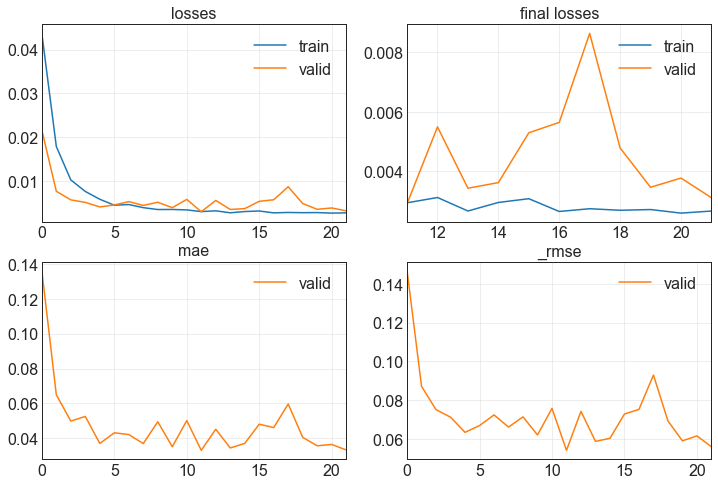

17.183597803115845                                                                                                     
[0.002670325106009841, 0.0031188717111945152, 0.0333612896502018, 0.05584685504436493]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 100, 'fc_dropout': 0.5, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.5, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
  3%|█▎                                           | 3/100 [01:19<45:11, 27.96s/trial, best loss: 0.0031188717111945152]

No improvement since epoch 31: early stopping                                                                          
  3%|█▎                                           | 3/100 [01:50<45:11, 27.96s/trial, best loss: 0.0031188717111945152]

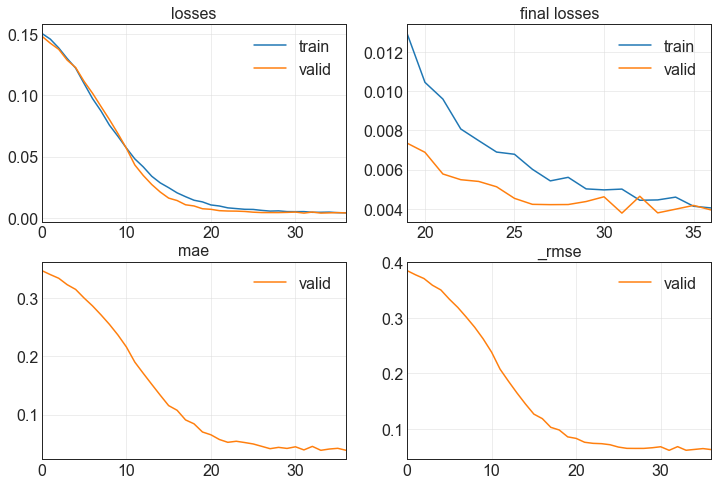

31.427428007125854                                                                                                     
[0.004040962550789118, 0.003936105407774448, 0.03849859535694122, 0.06273838877677917]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.5, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
  4%|█▊                                           | 4/100 [01:51<46:38, 29.15s/trial, best loss: 0.0031188717111945152]

No improvement since epoch 10: early stopping                                                                          
  4%|█▊                                           | 4/100 [02:17<46:38, 29.15s/trial, best loss: 0.0031188717111945152]

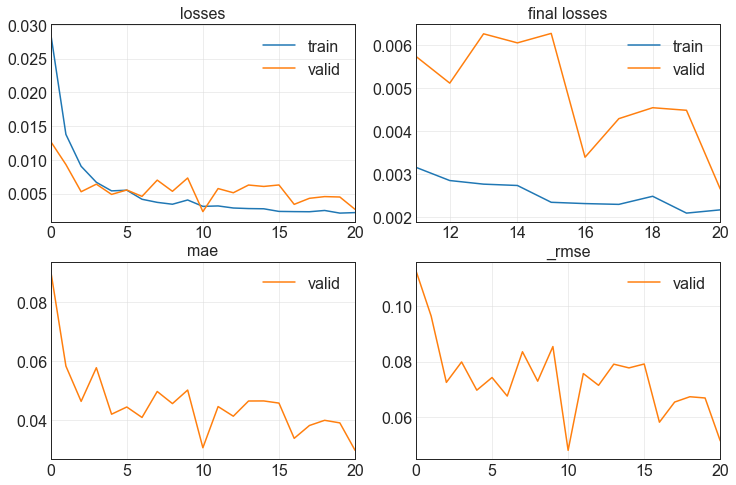

26.660120964050293                                                                                                     
[0.0021696160547435284, 0.002651647664606571, 0.029711605980992317, 0.05149415135383606]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
  5%|██▎                                           | 5/100 [02:18<45:13, 28.57s/trial, best loss: 0.002651647664606571]

No improvement since epoch 20: early stopping                                                                          
  5%|██▎                                           | 5/100 [02:25<45:13, 28.57s/trial, best loss: 0.002651647664606571]

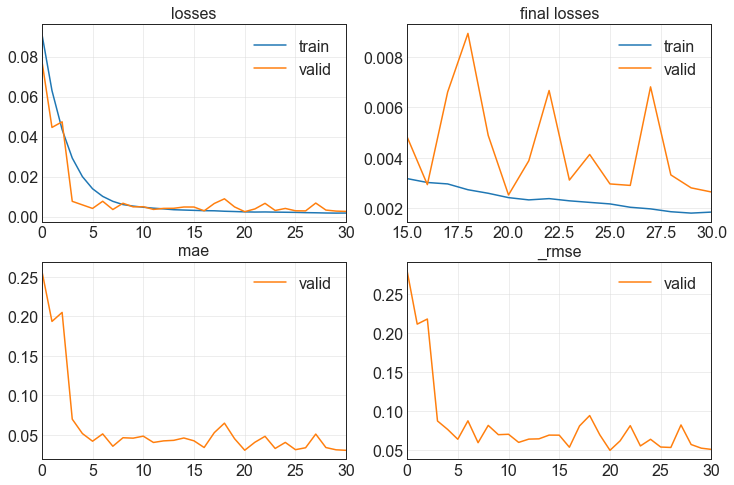

7.665941953659058                                                                                                      
[0.0018412466160953045, 0.002640236634761095, 0.030321812257170677, 0.051383234560489655]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 100, 'fc_dropout': 0.5, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
  6%|██▊                                           | 6/100 [02:26<35:10, 22.45s/trial, best loss: 0.002640236634761095]

No improvement since epoch 17: early stopping                                                                          
  6%|██▊                                           | 6/100 [02:36<35:10, 22.45s/trial, best loss: 0.002640236634761095]

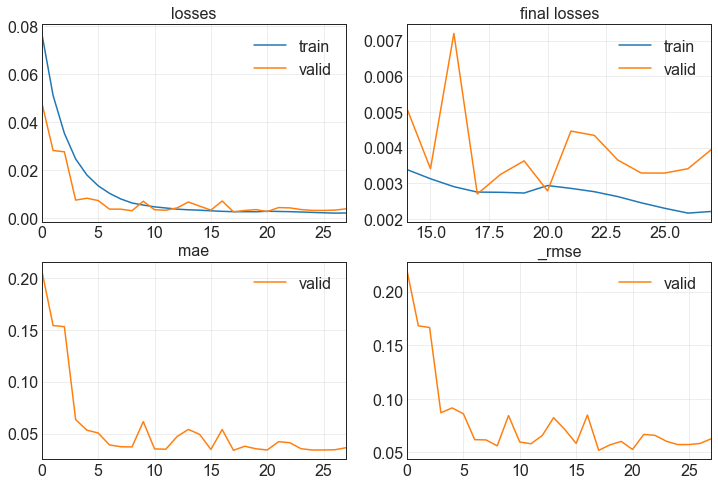

10.795740604400635                                                                                                     
[0.002212747698649764, 0.003949443809688091, 0.036355502903461456, 0.06284459680318832]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.5, 'hidden_size': 100, 'kss': (5, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
  7%|███▏                                          | 7/100 [02:37<29:37, 19.12s/trial, best loss: 0.002640236634761095]

No improvement since epoch 22: early stopping                                                                          
  7%|███▏                                          | 7/100 [03:10<29:37, 19.12s/trial, best loss: 0.002640236634761095]

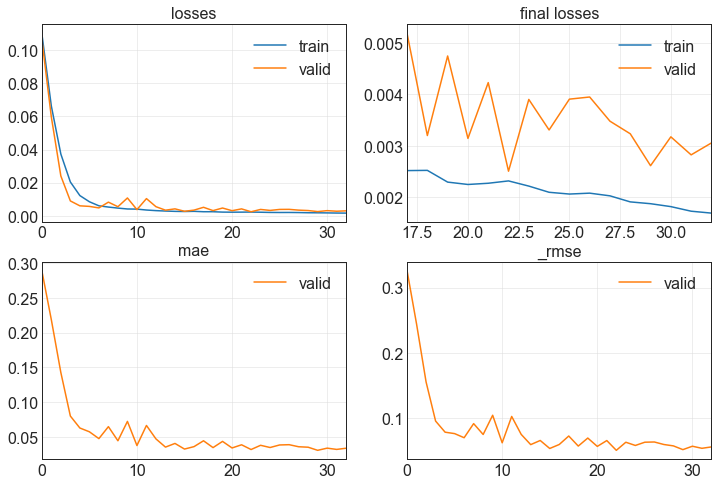

33.512158155441284                                                                                                     
[0.0016888923710212111, 0.0030548875220119953, 0.03358932584524155, 0.05527103692293167]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 100, 'fc_dropout': 0.0, 'hidden_size': 100, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.8, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
  8%|███▋                                          | 8/100 [03:11<36:09, 23.59s/trial, best loss: 0.002640236634761095]

No improvement since epoch 17: early stopping                                                                          
  8%|███▋                                          | 8/100 [03:17<36:09, 23.59s/trial, best loss: 0.002640236634761095]

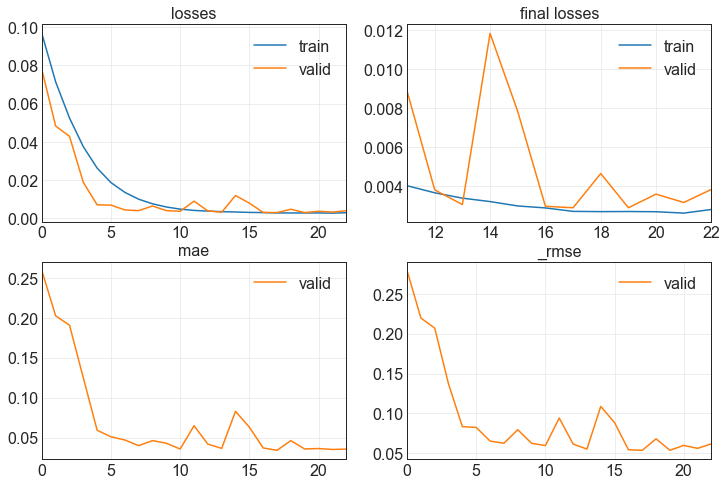

5.968256950378418                                                                                                      
[0.002807068172842264, 0.0038383216597139835, 0.035431068390607834, 0.06195418909192085]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 100, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
  9%|████▏                                         | 9/100 [03:18<28:00, 18.46s/trial, best loss: 0.002640236634761095]

No improvement since epoch 12: early stopping                                                                          
  9%|████▏                                         | 9/100 [03:28<28:00, 18.46s/trial, best loss: 0.002640236634761095]

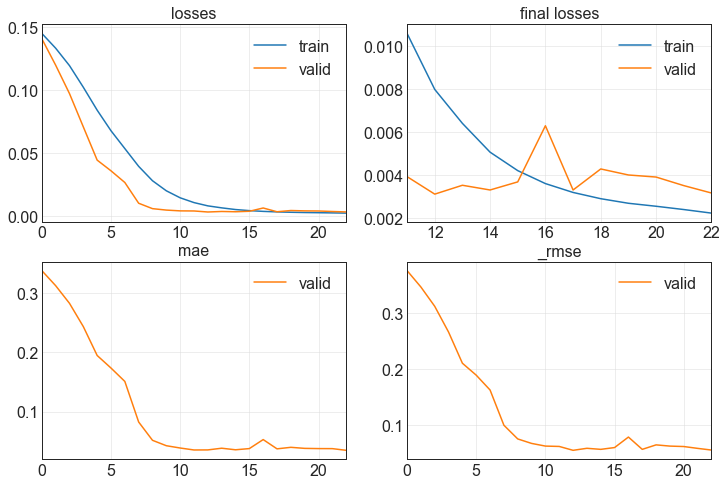

10.122854709625244                                                                                                     
[0.0022178140934556723, 0.0031538226176053286, 0.03489158675074577, 0.05615890398621559]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 20, 'fc_dropout': 0.5, 'hidden_size': 100, 'kss': (3, 3, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 10%|████▌                                        | 10/100 [03:29<24:11, 16.12s/trial, best loss: 0.002640236634761095]

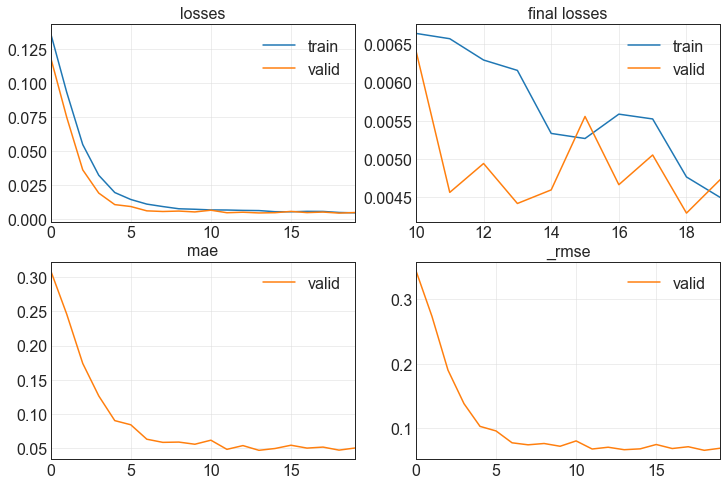

26.561665296554565                                                                                                     
[0.004495834931731224, 0.004731446038931608, 0.050494324415922165, 0.06878551095724106]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.0, 'hidden_size': 100, 'kss': (5, 5, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.8, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 11%|████▉                                        | 11/100 [03:56<28:47, 19.41s/trial, best loss: 0.002640236634761095]

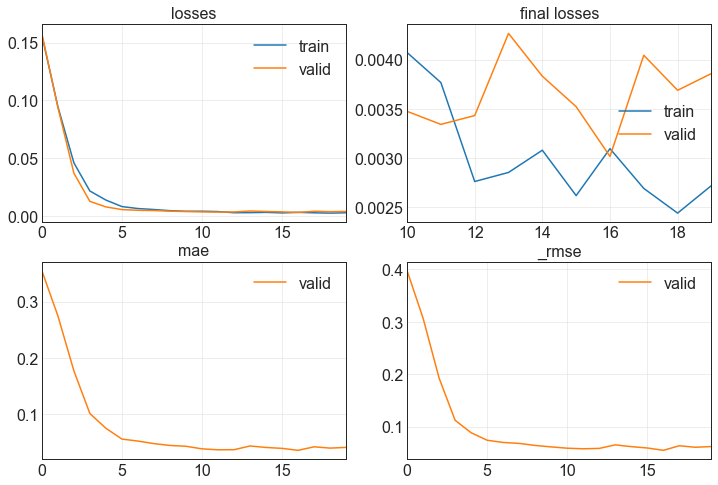

47.085383892059326                                                                                                     
[0.0027198768220841885, 0.003859136486425996, 0.04092143103480339, 0.06212195008993149]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 100, 'kss': (5, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.5, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 12%|█████▍                                       | 12/100 [04:43<40:51, 27.86s/trial, best loss: 0.002640236634761095]

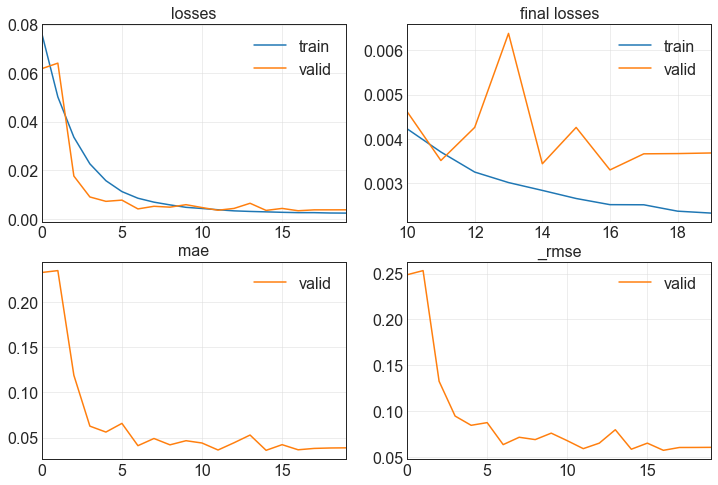

7.29056453704834                                                                                                       
[0.0023274875711649656, 0.003683648305013776, 0.03871581330895424, 0.06069306284189224]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 20, 'fc_dropout': 0.0, 'hidden_size': 100, 'kss': (3, 3, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.3, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 13%|█████▊                                       | 13/100 [04:51<31:41, 21.85s/trial, best loss: 0.002640236634761095]

No improvement since epoch 10: early stopping                                                                          
 13%|█████▊                                       | 13/100 [04:56<31:41, 21.85s/trial, best loss: 0.002640236634761095]

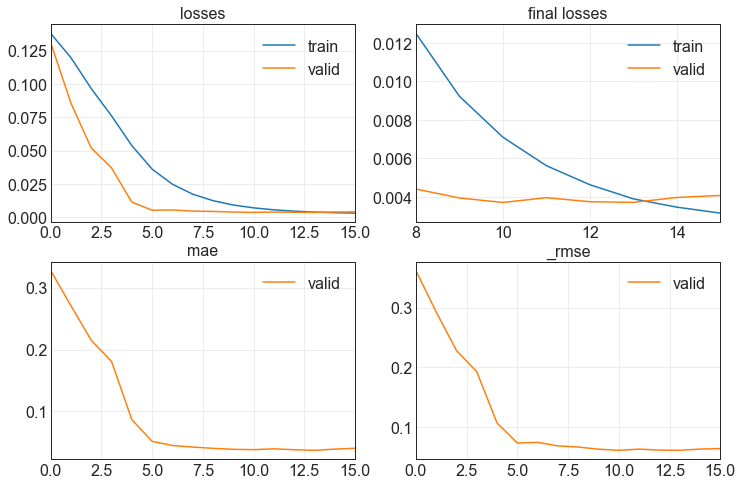

5.032922029495239                                                                                                      
[0.0031621630769222975, 0.0040797218680381775, 0.040636707097291946, 0.06387269496917725]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (5, 5, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.8, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 14%|██████▎                                      | 14/100 [04:57<24:18, 16.96s/trial, best loss: 0.002640236634761095]

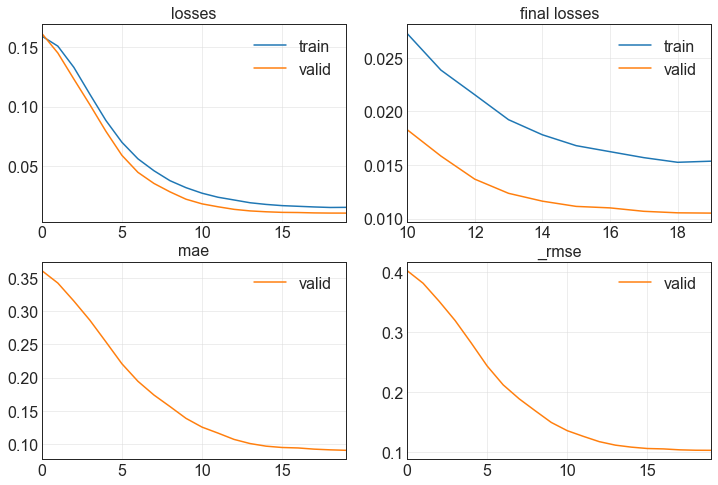

12.053183317184448                                                                                                     
[0.01536126621067524, 0.010518373921513557, 0.09058943390846252, 0.10255912691354752]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 100, 'fc_dropout': 0.0, 'hidden_size': 100, 'kss': (3, 3, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.8, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 15%|██████▊                                      | 15/100 [05:09<22:09, 15.64s/trial, best loss: 0.002640236634761095]

No improvement since epoch 15: early stopping                                                                          
 15%|██████▊                                      | 15/100 [05:48<22:09, 15.64s/trial, best loss: 0.002640236634761095]

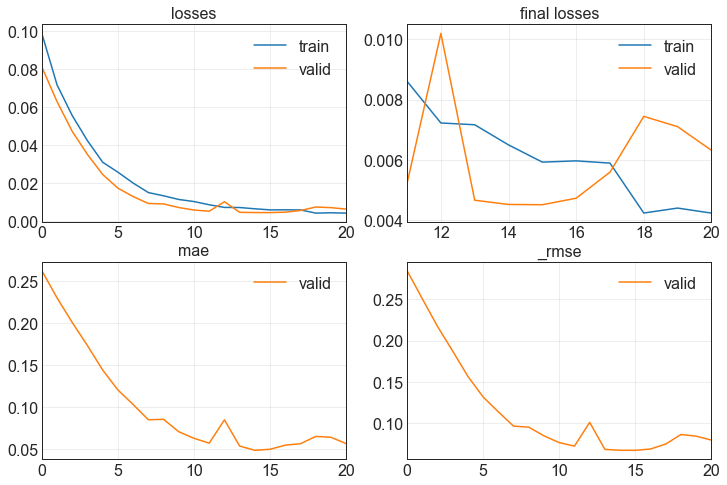

39.04298162460327                                                                                                      
[0.00423097750172019, 0.006317817606031895, 0.05635801702737808, 0.07948470115661621]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 100, 'fc_dropout': 0.5, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.5, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 16%|███████▏                                     | 16/100 [05:49<31:57, 22.82s/trial, best loss: 0.002640236634761095]

No improvement since epoch 14: early stopping                                                                          
 16%|███████▏                                     | 16/100 [06:18<31:57, 22.82s/trial, best loss: 0.002640236634761095]

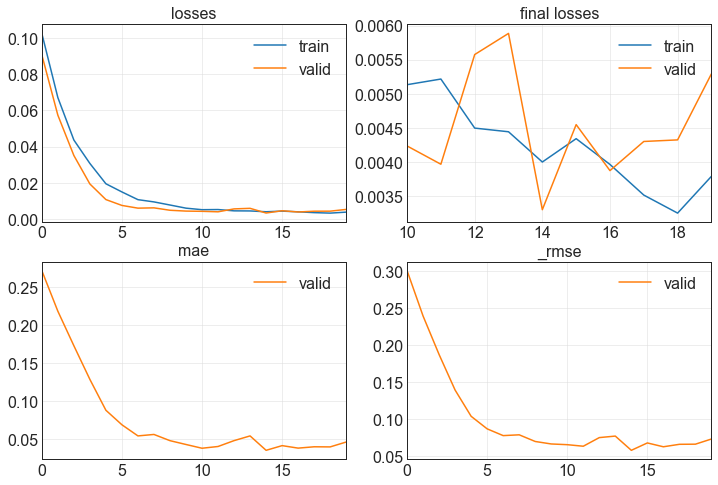

29.617006540298462                                                                                                     
[0.0037878460716456175, 0.00529248733073473, 0.04628343507647514, 0.07274948805570602]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.5, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 17%|███████▋                                     | 17/100 [06:19<34:36, 25.02s/trial, best loss: 0.002640236634761095]

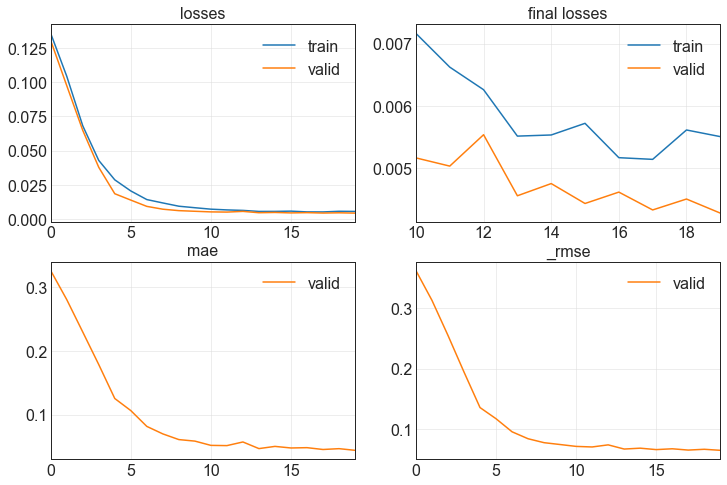

15.95252275466919                                                                                                      
[0.005510075483471155, 0.004285640548914671, 0.043838124722242355, 0.0654648020863533]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 100, 'fc_dropout': 0.5, 'hidden_size': 50, 'kss': (3, 3, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 18%|████████                                     | 18/100 [06:35<30:40, 22.45s/trial, best loss: 0.002640236634761095]

No improvement since epoch 20: early stopping                                                                          
 18%|████████                                     | 18/100 [06:43<30:40, 22.45s/trial, best loss: 0.002640236634761095]

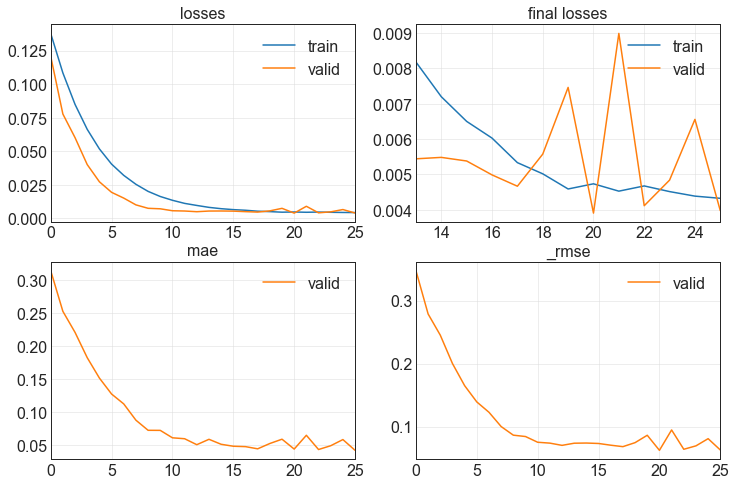

8.519342422485352                                                                                                      
[0.0043256813660264015, 0.003974985796958208, 0.04203224554657936, 0.06304748356342316]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (5, 5, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 19%|████████▌                                    | 19/100 [06:44<24:52, 18.43s/trial, best loss: 0.002640236634761095]

No improvement since epoch 12: early stopping                                                                          
 19%|████████▌                                    | 19/100 [07:19<24:52, 18.43s/trial, best loss: 0.002640236634761095]

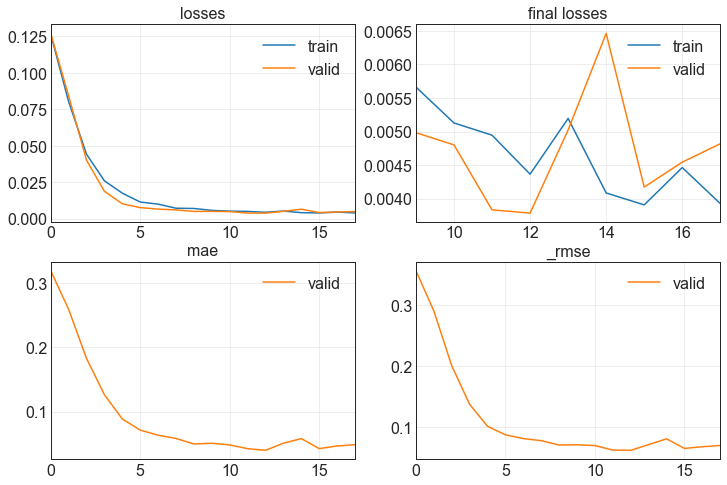

35.41358518600464                                                                                                      
[0.003926388919353485, 0.004818256013095379, 0.048578619956970215, 0.06941366195678711]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 20%|█████████                                    | 20/100 [07:20<31:33, 23.67s/trial, best loss: 0.002640236634761095]

No improvement since epoch 7: early stopping                                                                           
 20%|█████████                                    | 20/100 [07:32<31:33, 23.67s/trial, best loss: 0.002640236634761095]

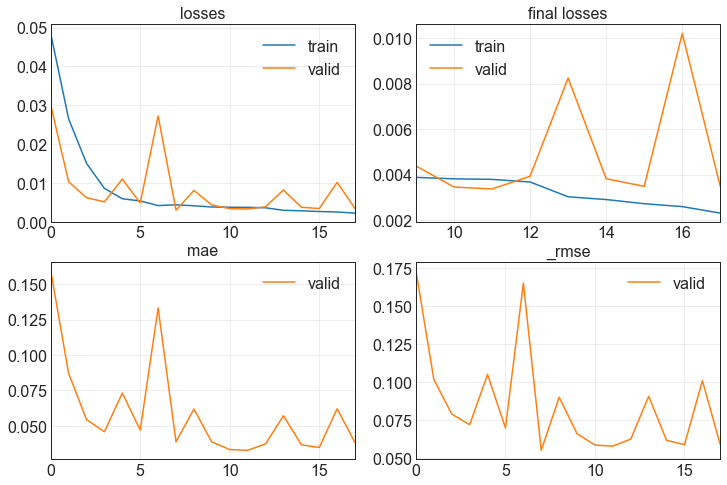

12.049771547317505                                                                                                     
[0.0023050238378345966, 0.003476075129583478, 0.03806741535663605, 0.05895824730396271]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 21%|█████████▍                                   | 21/100 [07:33<26:47, 20.34s/trial, best loss: 0.002640236634761095]

No improvement since epoch 25: early stopping                                                                          
 21%|█████████▍                                   | 21/100 [07:56<26:47, 20.34s/trial, best loss: 0.002640236634761095]

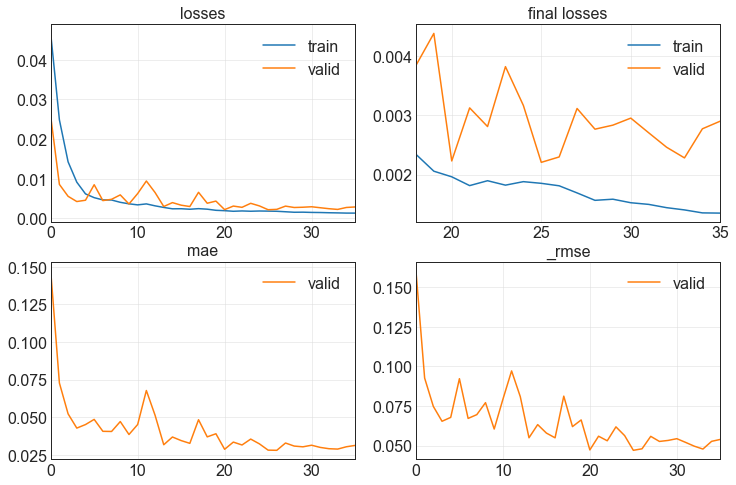

23.696747303009033                                                                                                     
[0.0013528026174753904, 0.002902211155742407, 0.03130514174699783, 0.05387217551469803]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 22%|█████████▉                                   | 22/100 [07:57<27:57, 21.50s/trial, best loss: 0.002640236634761095]

No improvement since epoch 27: early stopping                                                                          
 22%|█████████▉                                   | 22/100 [08:50<27:57, 21.50s/trial, best loss: 0.002640236634761095]

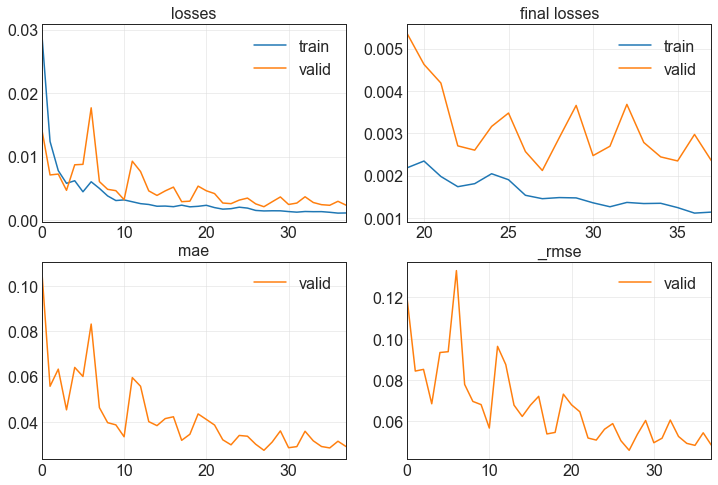

52.87337875366211                                                                                                      
[0.0011355378665030003, 0.002349839312955737, 0.028993280604481697, 0.04847514256834984]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 23%|██████████▎                                  | 23/100 [08:51<39:52, 31.07s/trial, best loss: 0.002349839312955737]

No improvement since epoch 10: early stopping                                                                          
 23%|██████████▎                                  | 23/100 [09:05<39:52, 31.07s/trial, best loss: 0.002349839312955737]

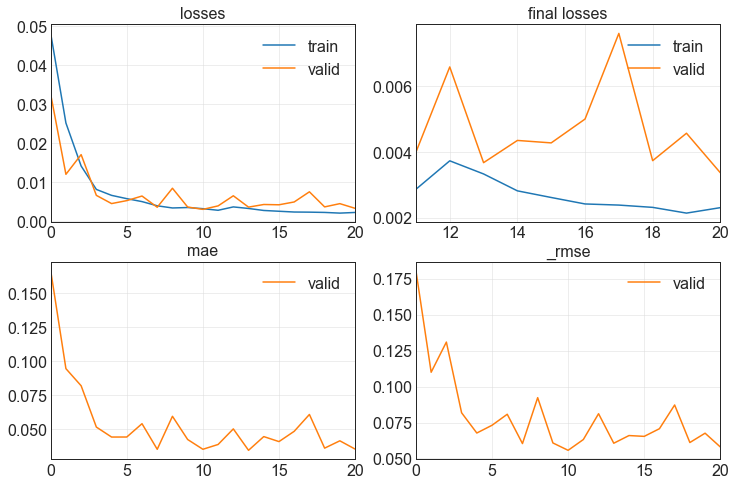

15.259292364120483                                                                                                     
[0.0023041358217597008, 0.0033655324950814247, 0.03536982089281082, 0.05801320821046829]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 24%|██████████▊                                  | 24/100 [09:06<33:33, 26.49s/trial, best loss: 0.002349839312955737]

No improvement since epoch 13: early stopping                                                                          
 24%|██████████▊                                  | 24/100 [09:17<33:33, 26.49s/trial, best loss: 0.002349839312955737]

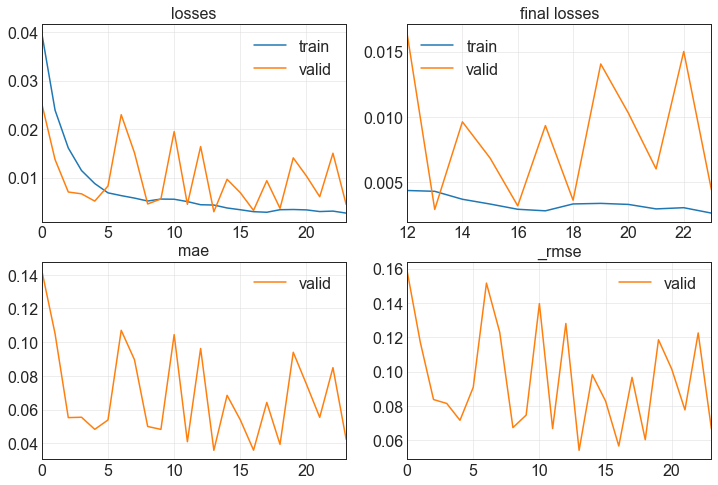

10.686492443084717                                                                                                     
[0.0026501831598579884, 0.004431441426277161, 0.04226047545671463, 0.06656907498836517]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 25%|███████████▎                                 | 25/100 [09:18<27:23, 21.91s/trial, best loss: 0.002349839312955737]

No improvement since epoch 14: early stopping                                                                          
 25%|███████████▎                                 | 25/100 [09:53<27:23, 21.91s/trial, best loss: 0.002349839312955737]

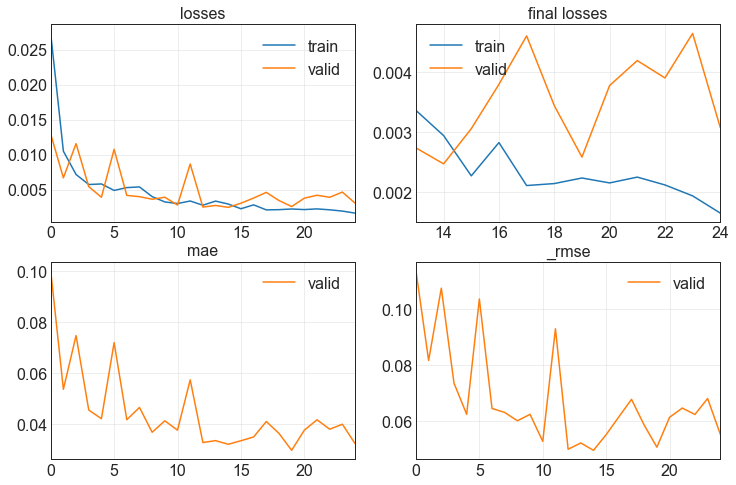

35.72394394874573                                                                                                      
[0.0016473698196932673, 0.003075207117944956, 0.032379962503910065, 0.055454548448324203]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 26%|███████████▋                                 | 26/100 [09:54<32:19, 26.21s/trial, best loss: 0.002349839312955737]

No improvement since epoch 2: early stopping                                                                           
 26%|███████████▋                                 | 26/100 [10:13<32:19, 26.21s/trial, best loss: 0.002349839312955737]

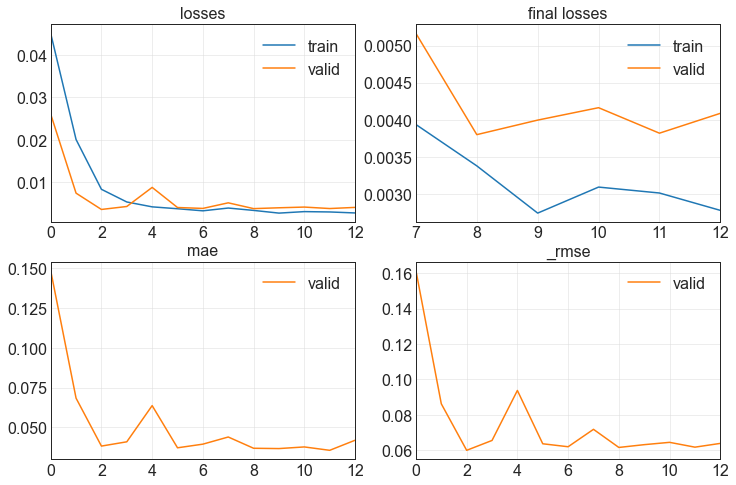

19.70673155784607                                                                                                      
[0.0027796709910035133, 0.00408699968829751, 0.04188964143395424, 0.06392964720726013]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 27%|████████████▏                                | 27/100 [10:14<29:42, 24.42s/trial, best loss: 0.002349839312955737]

No improvement since epoch 17: early stopping                                                                          
 27%|████████████▏                                | 27/100 [10:21<29:42, 24.42s/trial, best loss: 0.002349839312955737]

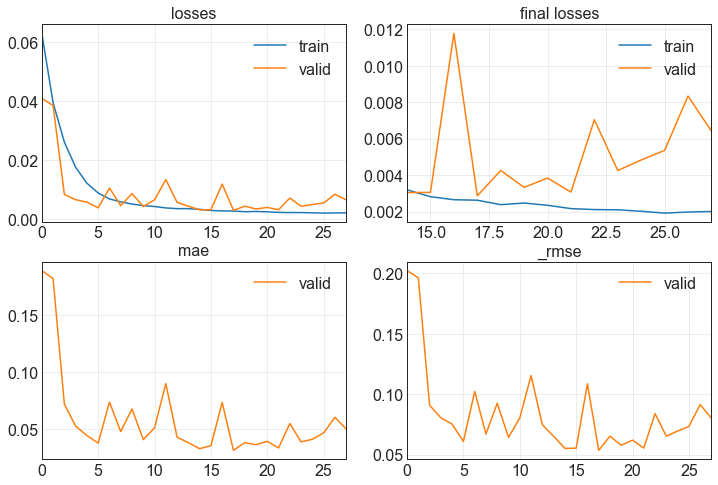

7.742245435714722                                                                                                      
[0.0020033889450132847, 0.006417358294129372, 0.04983344301581383, 0.0801084116101265]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 28%|████████████▌                                | 28/100 [10:22<23:29, 19.57s/trial, best loss: 0.002349839312955737]

No improvement since epoch 4: early stopping                                                                           
 28%|████████████▌                                | 28/100 [10:36<23:29, 19.57s/trial, best loss: 0.002349839312955737]

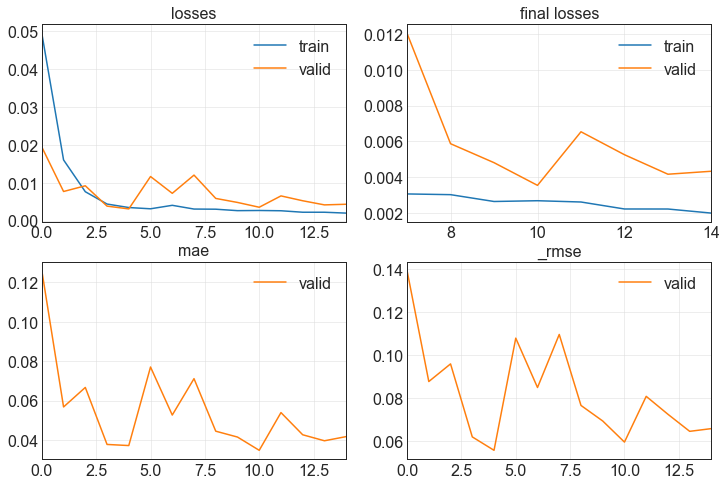

13.697518110275269                                                                                                     
[0.0020030878949910402, 0.004338715225458145, 0.041748046875, 0.06586892157793045]                                     
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 29%|█████████████                                | 29/100 [10:37<21:16, 17.98s/trial, best loss: 0.002349839312955737]

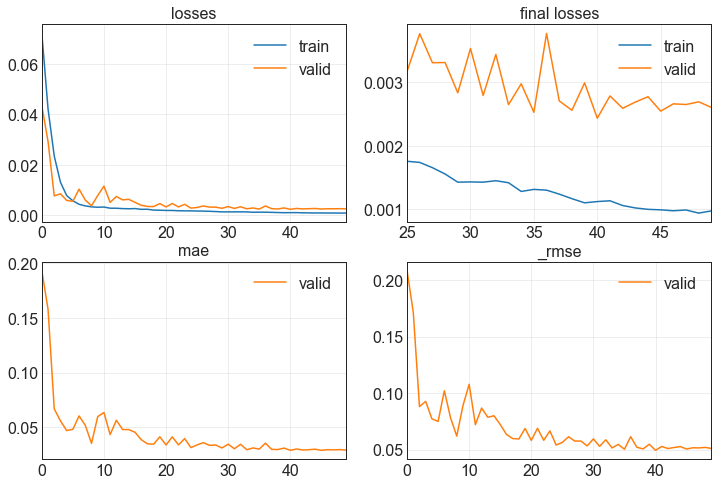

36.967509746551514                                                                                                     
[0.0009772699559107423, 0.0026059551164507866, 0.029031721875071526, 0.051048554480075836]                             
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 30%|█████████████▌                               | 30/100 [11:14<27:48, 23.83s/trial, best loss: 0.002349839312955737]

No improvement since epoch 5: early stopping                                                                           
 30%|█████████████▌                               | 30/100 [11:28<27:48, 23.83s/trial, best loss: 0.002349839312955737]

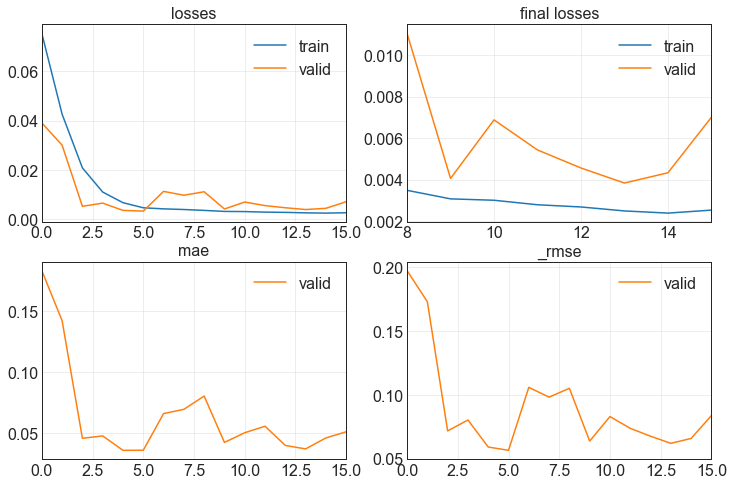

13.97578763961792                                                                                                      
[0.0025253051426261663, 0.00700791971758008, 0.05119747295975685, 0.08371331542730331]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (5, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 31%|█████████████▉                               | 31/100 [11:29<24:12, 21.06s/trial, best loss: 0.002349839312955737]

No improvement since epoch 19: early stopping                                                                          
 31%|█████████████▉                               | 31/100 [11:51<24:12, 21.06s/trial, best loss: 0.002349839312955737]

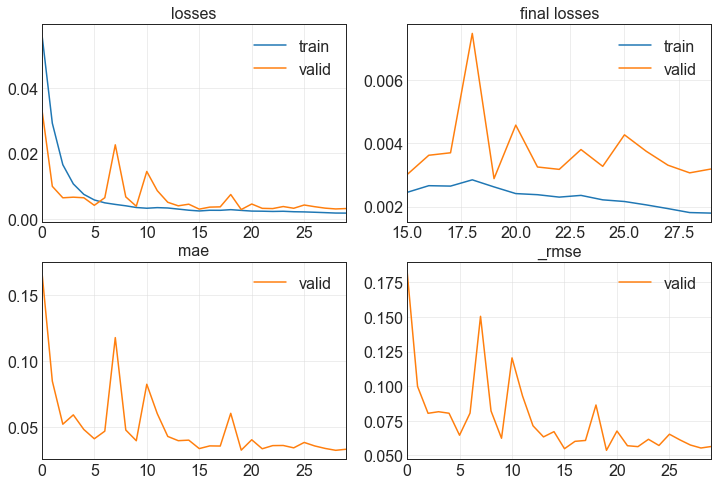

22.34769868850708                                                                                                      
[0.0017916759243234992, 0.003187777940183878, 0.032953694462776184, 0.056460410356521606]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 32%|██████████████▍                              | 32/100 [11:52<24:28, 21.60s/trial, best loss: 0.002349839312955737]

No improvement since epoch 25: early stopping                                                                          
 32%|██████████████▍                              | 32/100 [12:18<24:28, 21.60s/trial, best loss: 0.002349839312955737]

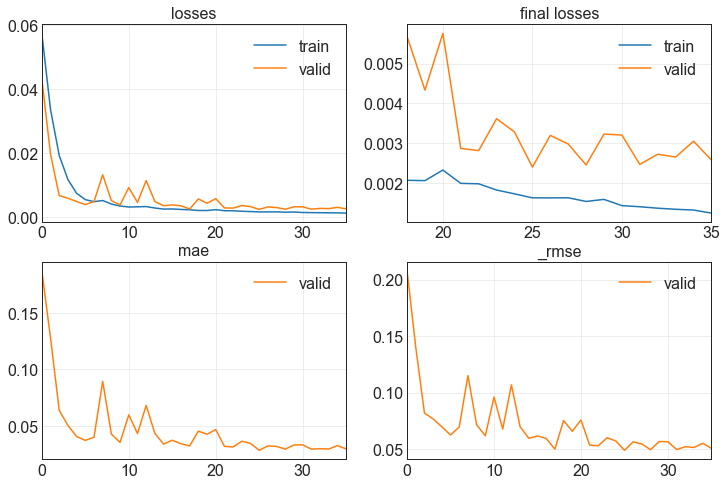

26.481709718704224                                                                                                     
[0.0012490663211792707, 0.002581455511972308, 0.02960769273340702, 0.050808027386665344]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 33%|██████████████▊                              | 33/100 [12:19<25:56, 23.23s/trial, best loss: 0.002349839312955737]

No improvement since epoch 15: early stopping                                                                          
 33%|██████████████▊                              | 33/100 [12:37<25:56, 23.23s/trial, best loss: 0.002349839312955737]

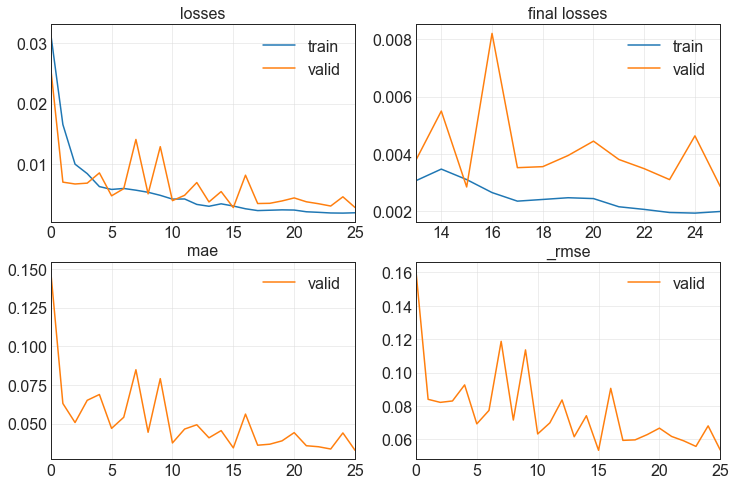

18.707199811935425                                                                                                     
[0.001997609157115221, 0.0028649927116930485, 0.03279818594455719, 0.05352562293410301]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 34%|███████████████▎                             | 34/100 [12:38<24:14, 22.03s/trial, best loss: 0.002349839312955737]

No improvement since epoch 33: early stopping                                                                          
 34%|███████████████▎                             | 34/100 [13:42<24:14, 22.03s/trial, best loss: 0.002349839312955737]

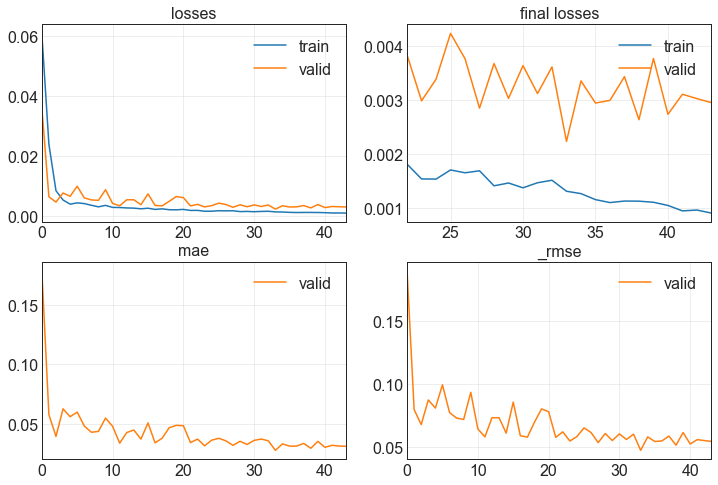

64.80666303634644                                                                                                      
[0.0009015044197440147, 0.002947635017335415, 0.031204385682940483, 0.05429212749004364]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 35%|███████████████▋                             | 35/100 [13:43<37:57, 35.04s/trial, best loss: 0.002349839312955737]

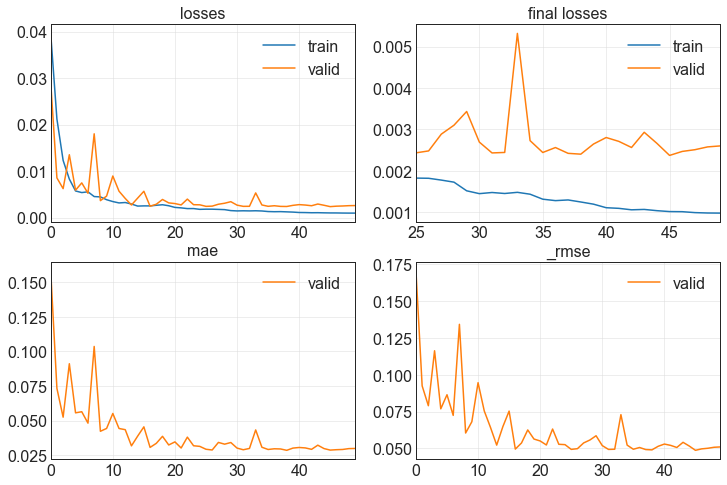

38.256170988082886                                                                                                     
[0.000978780211880803, 0.002601473592221737, 0.029950927942991257, 0.051004644483327866]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 36%|████████████████▏                            | 36/100 [14:22<38:35, 36.17s/trial, best loss: 0.002349839312955737]

No improvement since epoch 24: early stopping                                                                          
 36%|████████████████▏                            | 36/100 [15:00<38:35, 36.17s/trial, best loss: 0.002349839312955737]

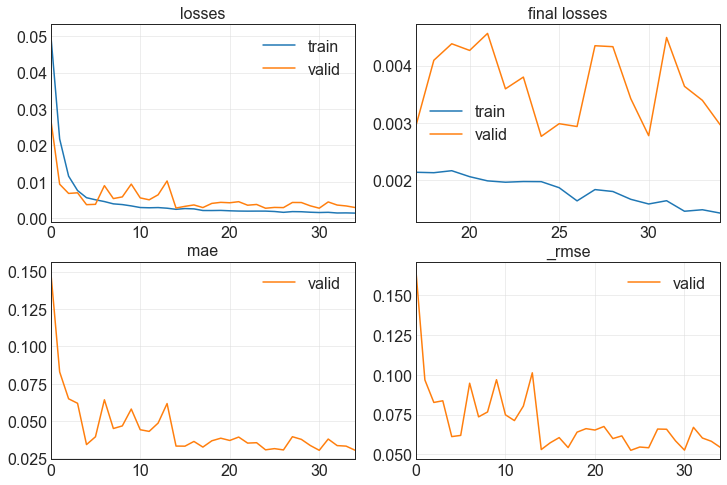

38.50845766067505                                                                                                      
[0.0014239824377000332, 0.00296240602619946, 0.030509106814861298, 0.054427992552518845]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 37%|████████████████▋                            | 37/100 [15:01<38:53, 37.04s/trial, best loss: 0.002349839312955737]

No improvement since epoch 12: early stopping                                                                          
 37%|████████████████▋                            | 37/100 [15:37<38:53, 37.04s/trial, best loss: 0.002349839312955737]

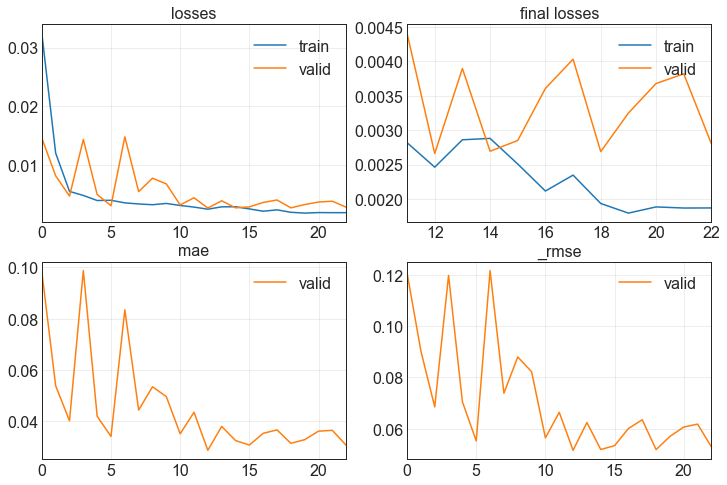

36.82452988624573                                                                                                      
[0.0018700427608564496, 0.002801199210807681, 0.03070734813809395, 0.052926357835531235]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 100, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 38%|█████████████████                            | 38/100 [15:38<38:22, 37.13s/trial, best loss: 0.002349839312955737]

No improvement since epoch 36: early stopping                                                                          
 38%|█████████████████                            | 38/100 [16:04<38:22, 37.13s/trial, best loss: 0.002349839312955737]

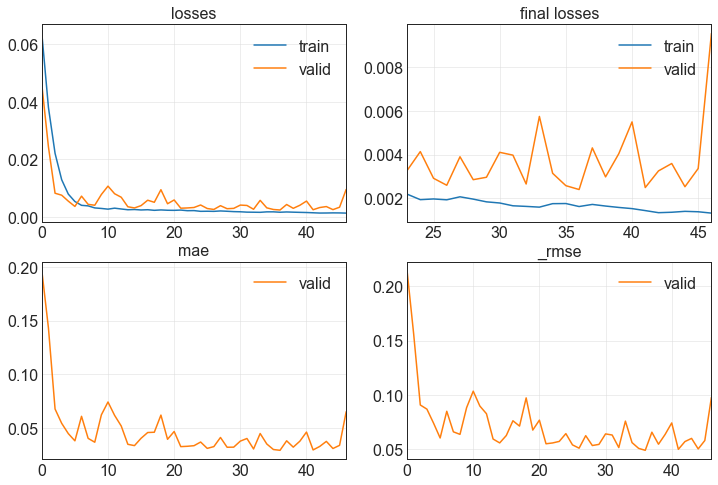

26.461832761764526                                                                                                     
[0.0013128265272825956, 0.009557382203638554, 0.06500782072544098, 0.09776186943054199]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (5, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 39%|█████████████████▌                           | 39/100 [16:05<34:39, 34.09s/trial, best loss: 0.002349839312955737]

No improvement since epoch 23: early stopping                                                                          
 39%|█████████████████▌                           | 39/100 [17:12<34:39, 34.09s/trial, best loss: 0.002349839312955737]

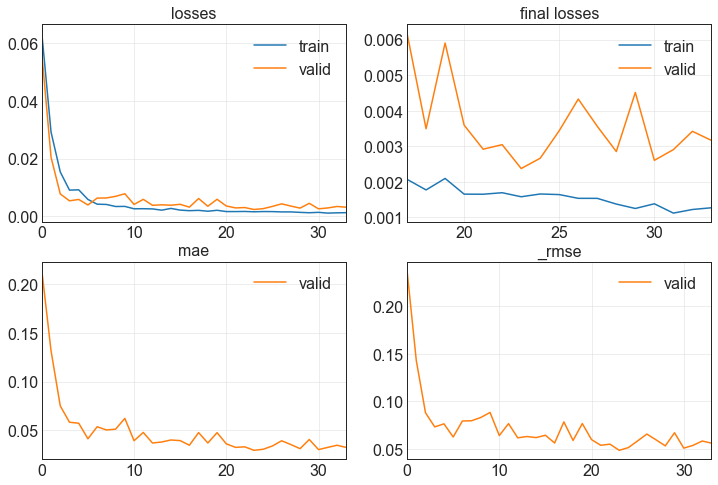

66.60456132888794                                                                                                      
[0.0012729635927826166, 0.0031661486718803644, 0.03243774548172951, 0.056268543004989624]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.5, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 40%|██████████████████                           | 40/100 [17:13<44:00, 44.02s/trial, best loss: 0.002349839312955737]

No improvement since epoch 17: early stopping                                                                          
 40%|██████████████████                           | 40/100 [17:58<44:00, 44.02s/trial, best loss: 0.002349839312955737]

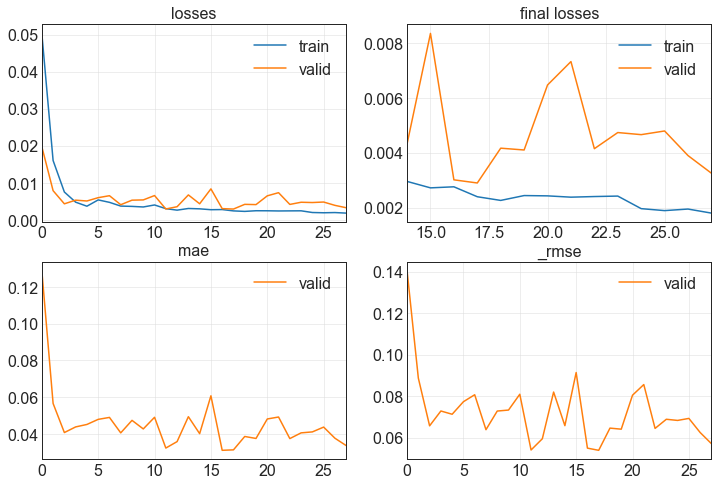

45.91242265701294                                                                                                      
[0.0018006121972575784, 0.003252573311328888, 0.03355634957551956, 0.057031333446502686]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 100, 'fc_dropout': 0.0, 'hidden_size': 50, 'kss': (3, 3, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 5}
LSTM_FCN                                                                                                               
 41%|██████████████████▍                          | 41/100 [17:59<44:00, 44.75s/trial, best loss: 0.002349839312955737]

No improvement since epoch 53: early stopping                                                                          
 41%|██████████████████▍                          | 41/100 [18:50<44:00, 44.75s/trial, best loss: 0.002349839312955737]

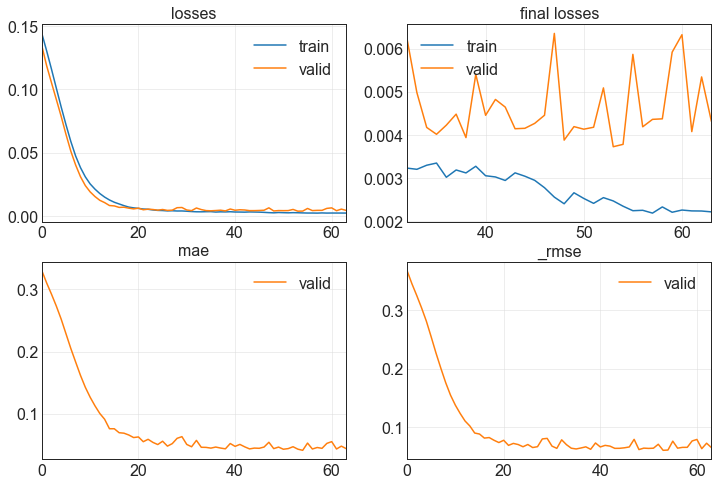

51.122706174850464                                                                                                     
[0.002209847792983055, 0.004309784155339003, 0.04347570985555649, 0.06564894318580627]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 42%|██████████████████▉                          | 42/100 [18:51<45:15, 46.82s/trial, best loss: 0.002349839312955737]

No improvement since epoch 33: early stopping                                                                          
 42%|██████████████████▉                          | 42/100 [19:35<45:15, 46.82s/trial, best loss: 0.002349839312955737]

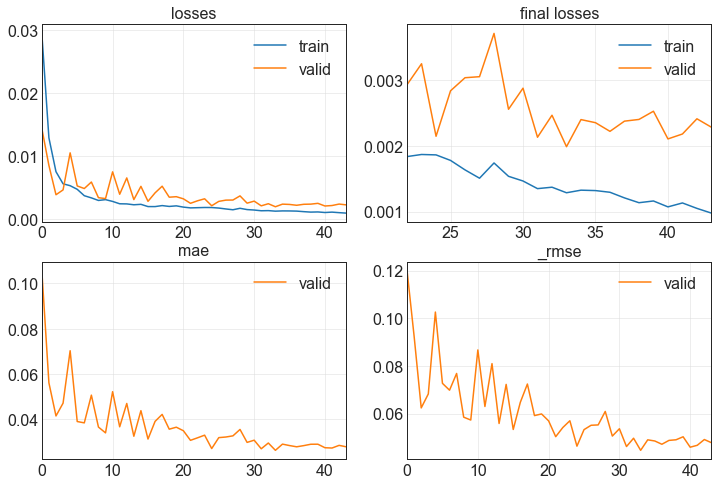

44.575817346572876                                                                                                     
[0.0009764173883013427, 0.0022810576483607292, 0.027873992919921875, 0.04776041954755783]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 100, 'kss': (5, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 43%|██████████████████▉                         | 43/100 [19:36<43:59, 46.31s/trial, best loss: 0.0022810576483607292]

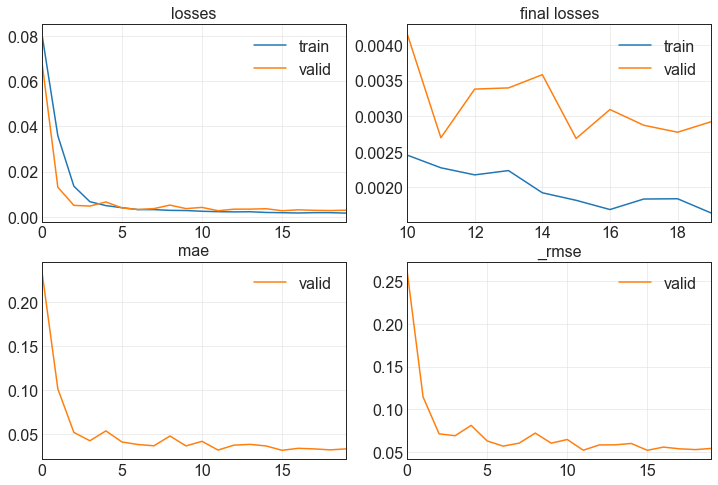

20.709345817565918                                                                                                     
[0.0016403461340814829, 0.0029246939811855555, 0.03299519419670105, 0.05408043786883354]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 44%|███████████████████▎                        | 44/100 [19:57<36:12, 38.79s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 6: early stopping                                                                           
 44%|███████████████████▎                        | 44/100 [20:07<36:12, 38.79s/trial, best loss: 0.0022810576483607292]

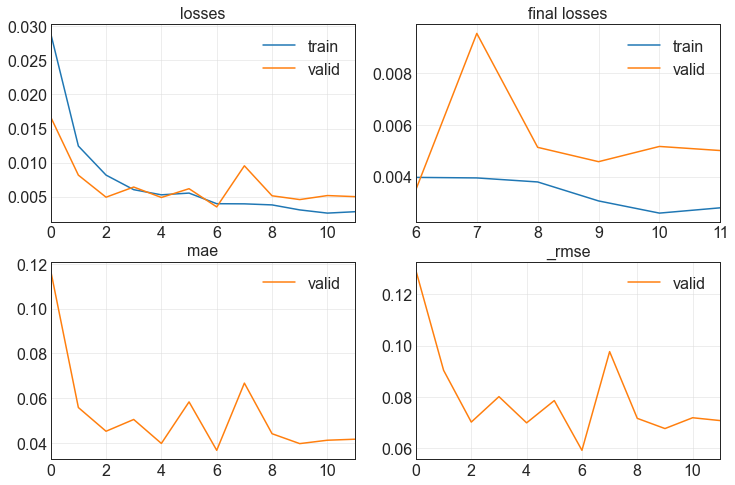

10.751336574554443                                                                                                     
[0.002799839014187455, 0.005010207649320364, 0.0415954515337944, 0.07078282535076141]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 100, 'fc_dropout': 0.3, 'hidden_size': 100, 'kss': (3, 3, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 45%|███████████████████▊                        | 45/100 [20:08<27:59, 30.54s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 31: early stopping                                                                          
 45%|███████████████████▊                        | 45/100 [20:51<27:59, 30.54s/trial, best loss: 0.0022810576483607292]

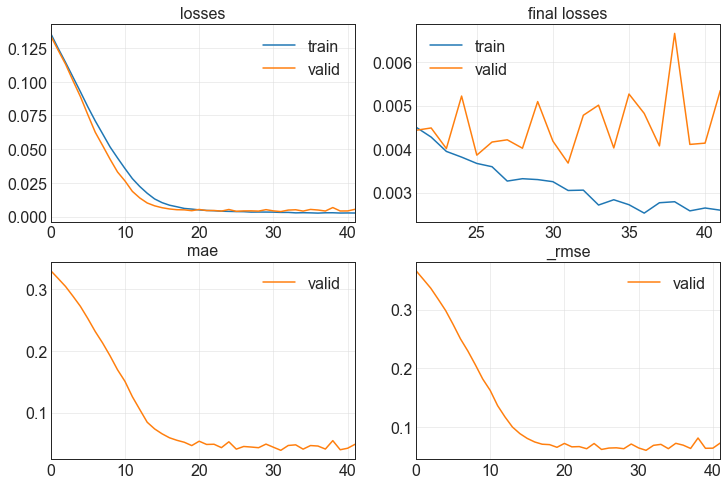

43.39717721939087                                                                                                      
[0.0025973247829824686, 0.0053472938016057014, 0.04846721142530441, 0.07312518358230591]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 46%|████████████████████▏                       | 46/100 [20:52<31:05, 34.55s/trial, best loss: 0.0022810576483607292]

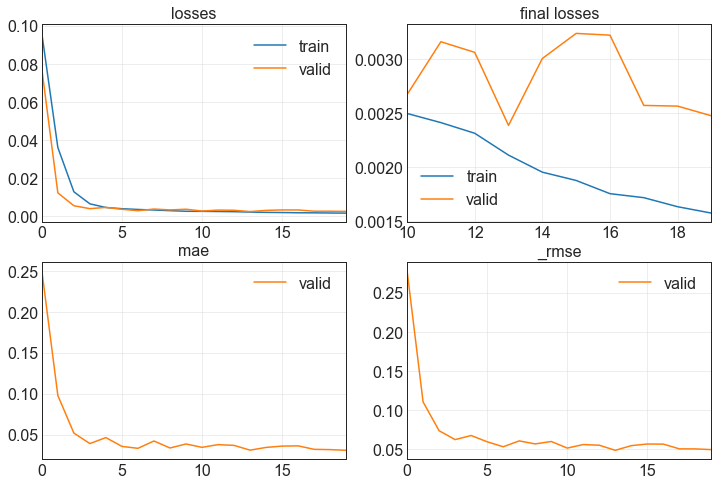

22.056436777114868                                                                                                     
[0.0015760196838527918, 0.0024753231555223465, 0.03070082888007164, 0.0497526153922081]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (5, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 47%|████████████████████▋                       | 47/100 [21:15<27:21, 30.97s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 2: early stopping                                                                           
 47%|████████████████████▋                       | 47/100 [21:22<27:21, 30.97s/trial, best loss: 0.0022810576483607292]

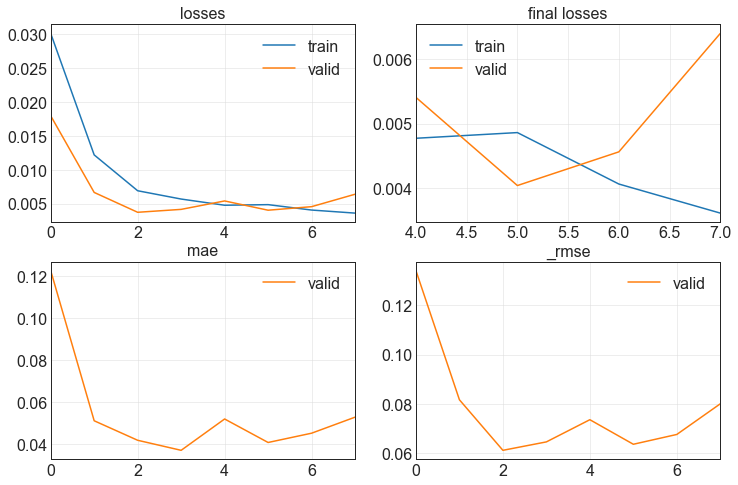

7.2204673290252686                                                                                                     
[0.0036112258676439524, 0.006398892495781183, 0.05290725454688072, 0.07999306917190552]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 100, 'fc_dropout': 0.3, 'hidden_size': 100, 'kss': (7, 5, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 48%|█████████████████████                       | 48/100 [21:23<20:48, 24.00s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 53: early stopping                                                                          
 48%|█████████████████████                       | 48/100 [24:01<20:48, 24.00s/trial, best loss: 0.0022810576483607292]

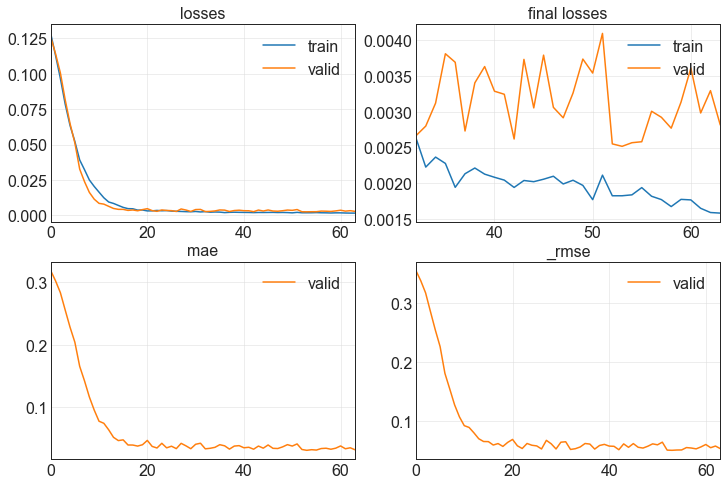

158.95199465751648                                                                                                     
[0.0015847351169213653, 0.0028152435552328825, 0.031443122774362564, 0.053058866411447525]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (3, 3, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 49%|█████████████████████▌                      | 49/100 [24:02<54:56, 64.64s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 4: early stopping                                                                           
 49%|█████████████████████▌                      | 49/100 [24:13<54:56, 64.64s/trial, best loss: 0.0022810576483607292]

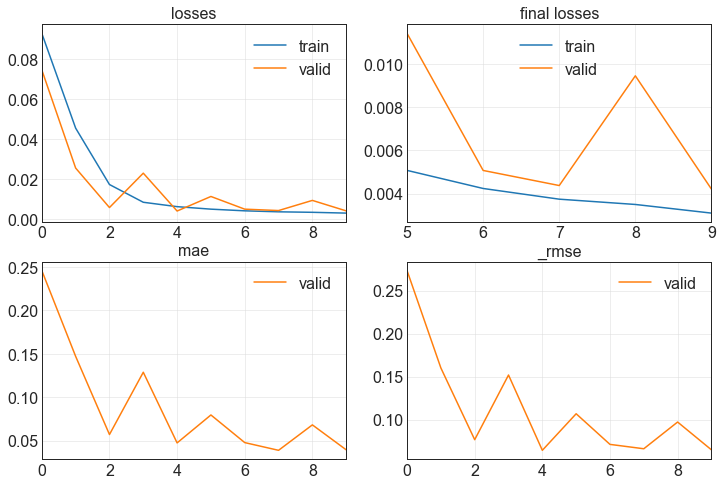

11.635679244995117                                                                                                     
[0.0031020338647067547, 0.004214255604892969, 0.03936780244112015, 0.06491729617118835]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 50, 'fc_dropout': 0.5, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 50%|██████████████████████                      | 50/100 [24:14<40:45, 48.91s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 19: early stopping                                                                          
 50%|██████████████████████                      | 50/100 [24:49<40:45, 48.91s/trial, best loss: 0.0022810576483607292]

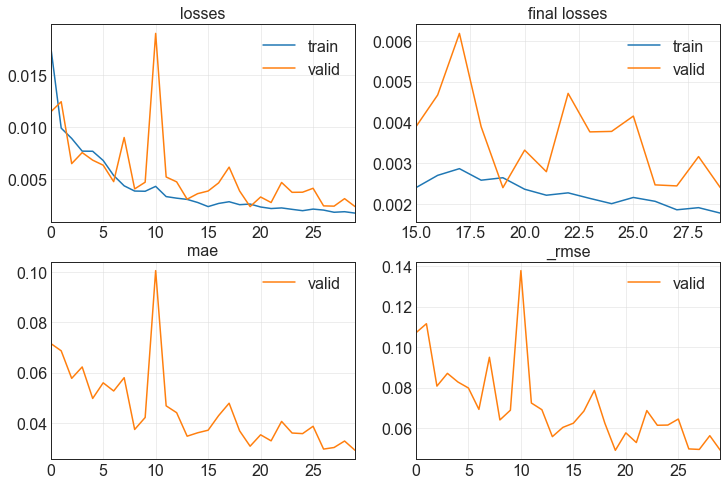

34.80181813240051                                                                                                      
[0.001778115751221776, 0.002403243910521269, 0.02914527803659439, 0.049022890627384186]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 100, 'kss': (5, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.3, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 51%|██████████████████████▍                     | 51/100 [24:50<36:37, 44.85s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 2: early stopping                                                                           
 51%|██████████████████████▍                     | 51/100 [25:00<36:37, 44.85s/trial, best loss: 0.0022810576483607292]

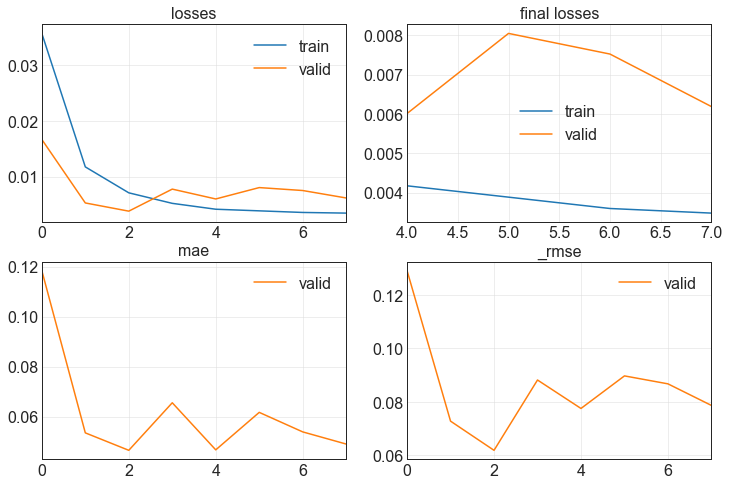

10.397363424301147                                                                                                     
[0.0034799724817276, 0.006186754442751408, 0.04900028556585312, 0.0786559209227562]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 100, 'fc_dropout': 0.5, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 52%|██████████████████████▉                     | 52/100 [25:01<27:44, 34.68s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 38: early stopping                                                                          
 52%|██████████████████████▉                     | 52/100 [26:29<27:44, 34.68s/trial, best loss: 0.0022810576483607292]

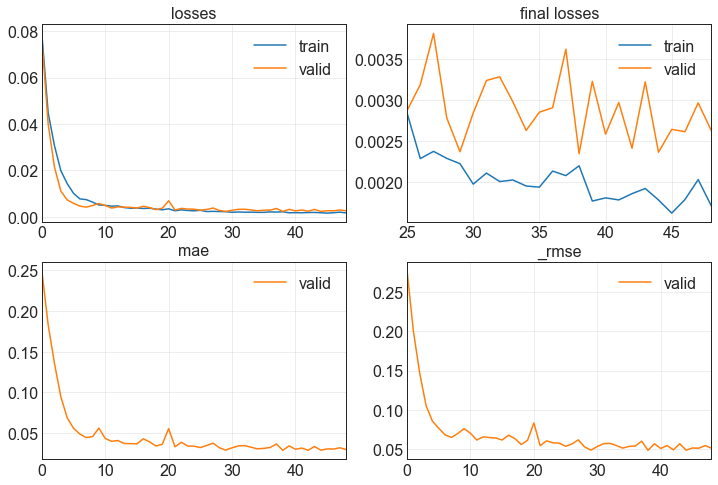

88.76406764984131                                                                                                      
[0.001709607196971774, 0.0026276635471731424, 0.03001200035214424, 0.05126073956489563]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 53%|███████████████████████▎                    | 53/100 [26:30<40:00, 51.07s/trial, best loss: 0.0022810576483607292]

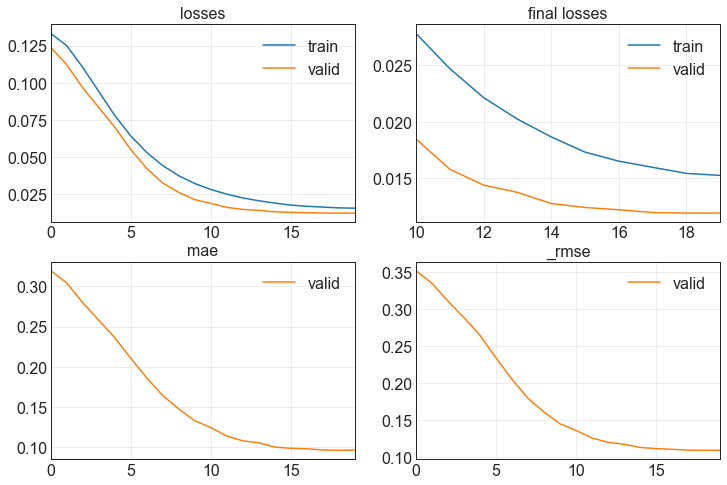

6.99465274810791                                                                                                       
[0.015253158286213875, 0.011914988048374653, 0.09677667915821075, 0.1091557964682579]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.5, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 54%|███████████████████████▊                    | 54/100 [26:38<29:09, 38.04s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 16: early stopping                                                                          
 54%|███████████████████████▊                    | 54/100 [27:01<29:09, 38.04s/trial, best loss: 0.0022810576483607292]

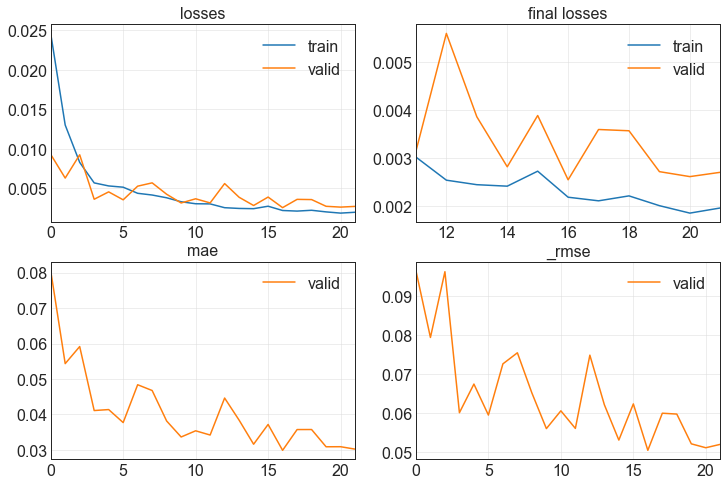

23.693729400634766                                                                                                     
[0.0019635118078440428, 0.002706014085561037, 0.03020423837006092, 0.05201936513185501]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.5, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 55%|████████████████████████▏                   | 55/100 [27:02<25:25, 33.90s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 3: early stopping                                                                           
 55%|████████████████████████▏                   | 55/100 [27:16<25:25, 33.90s/trial, best loss: 0.0022810576483607292]

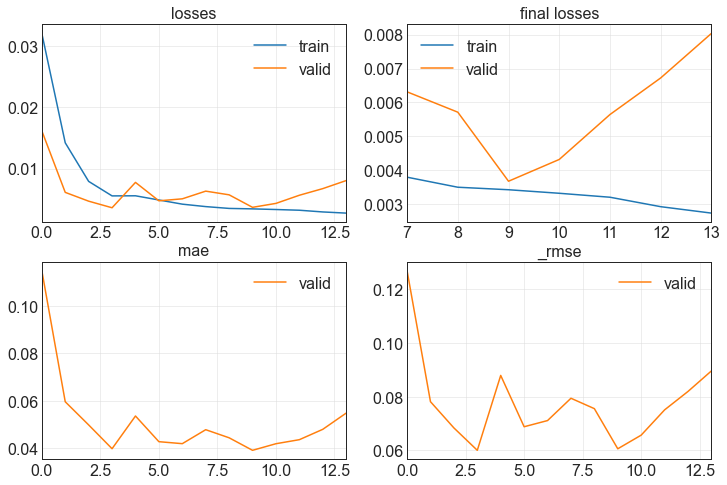

15.079554319381714                                                                                                     
[0.002733251778408885, 0.008036769926548004, 0.05481758713722229, 0.08964803069829941]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 100, 'kss': (5, 5, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 56%|████████████████████████▋                   | 56/100 [27:17<20:50, 28.42s/trial, best loss: 0.0022810576483607292]

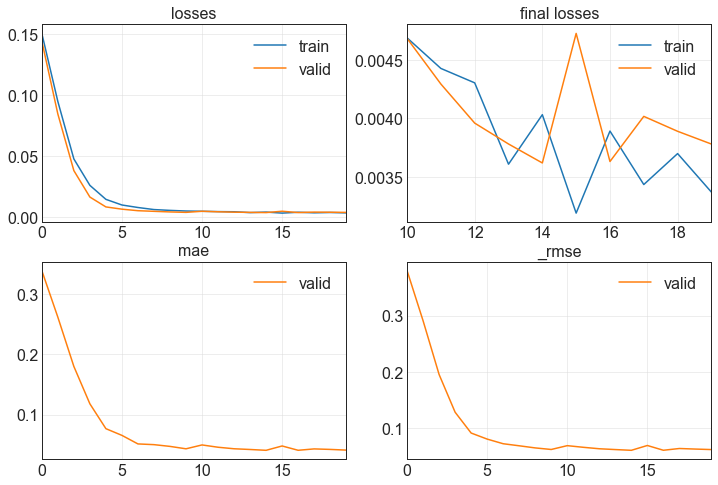

36.552130460739136                                                                                                     
[0.003368746256455779, 0.0037803943268954754, 0.04117099568247795, 0.061484914273023605]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.5, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.8, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 57%|█████████████████████████                   | 57/100 [27:55<22:14, 31.03s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 18: early stopping                                                                          
 57%|█████████████████████████                   | 57/100 [28:03<22:14, 31.03s/trial, best loss: 0.0022810576483607292]

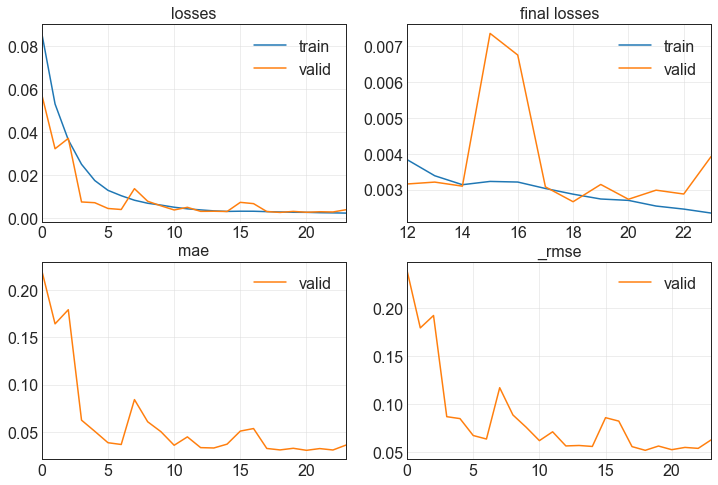

9.0777108669281                                                                                                        
[0.002347949892282486, 0.003935270477086306, 0.036043599247932434, 0.06273173540830612]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 100, 'fc_dropout': 0.3, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.5, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 58%|█████████████████████████▌                  | 58/100 [28:04<17:13, 24.61s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 11: early stopping                                                                          
 58%|█████████████████████████▌                  | 58/100 [28:29<17:13, 24.61s/trial, best loss: 0.0022810576483607292]

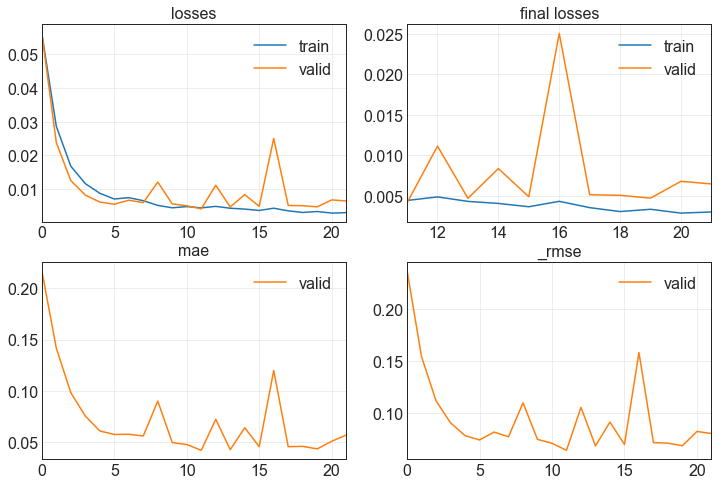

24.85926580429077                                                                                                      
[0.0030018785037100315, 0.0064644236117601395, 0.05700865760445595, 0.08040165156126022]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 59%|█████████████████████████▉                  | 59/100 [28:30<16:58, 24.85s/trial, best loss: 0.0022810576483607292]

No improvement since epoch 35: early stopping                                                                          
 59%|█████████████████████████▉                  | 59/100 [29:22<16:58, 24.85s/trial, best loss: 0.0022810576483607292]

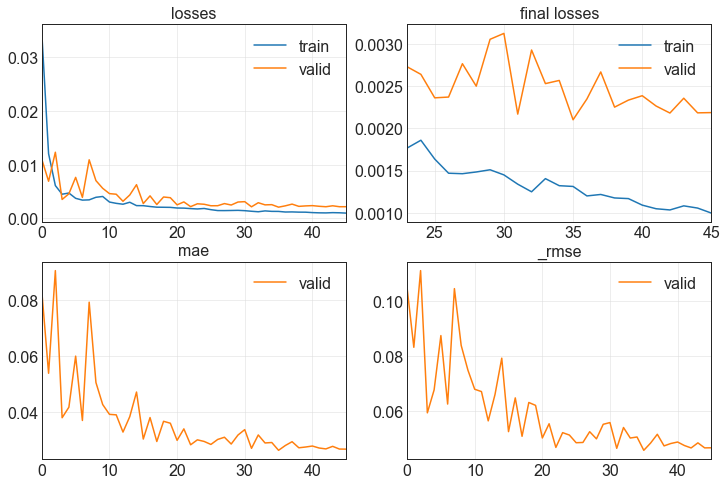

52.5146918296814                                                                                                       
[0.000996057060547173, 0.0021883677691221237, 0.02680373191833496, 0.046779993921518326]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 60%|██████████████████████████▍                 | 60/100 [29:23<22:12, 33.32s/trial, best loss: 0.0021883677691221237]

No improvement since epoch 17: early stopping                                                                          
 60%|██████████████████████████▍                 | 60/100 [29:55<22:12, 33.32s/trial, best loss: 0.0021883677691221237]

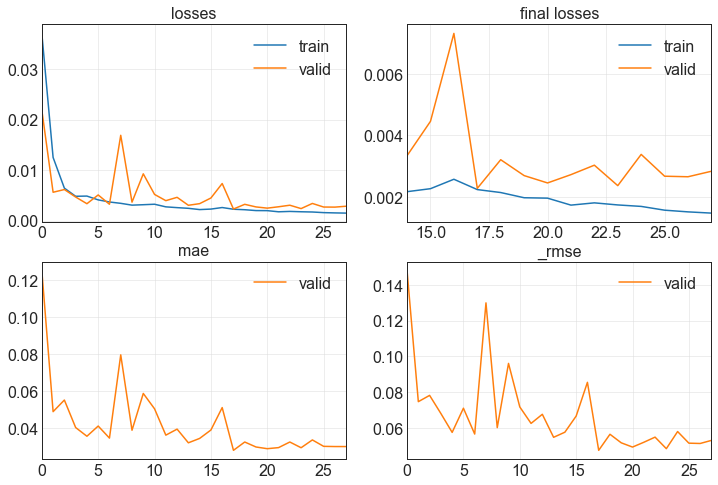

32.838998317718506                                                                                                     
[0.0014663474867120385, 0.002831311197951436, 0.030168961733579636, 0.0532100684940815]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 61%|██████████████████████████▊                 | 61/100 [29:56<21:40, 33.35s/trial, best loss: 0.0021883677691221237]

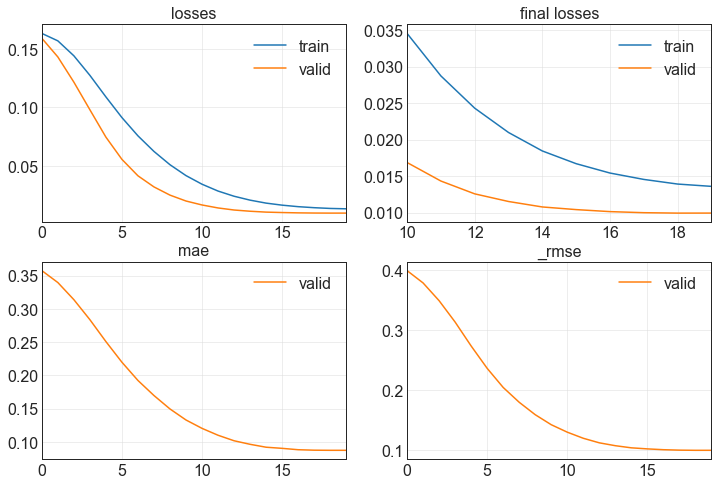

6.933974027633667                                                                                                      
[0.013596080243587494, 0.009934083558619022, 0.08714541792869568, 0.09966988116502762]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 62%|███████████████████████████▎                | 62/100 [30:04<16:12, 25.59s/trial, best loss: 0.0021883677691221237]

No improvement since epoch 11: early stopping                                                                          
 62%|███████████████████████████▎                | 62/100 [30:52<16:12, 25.59s/trial, best loss: 0.0021883677691221237]

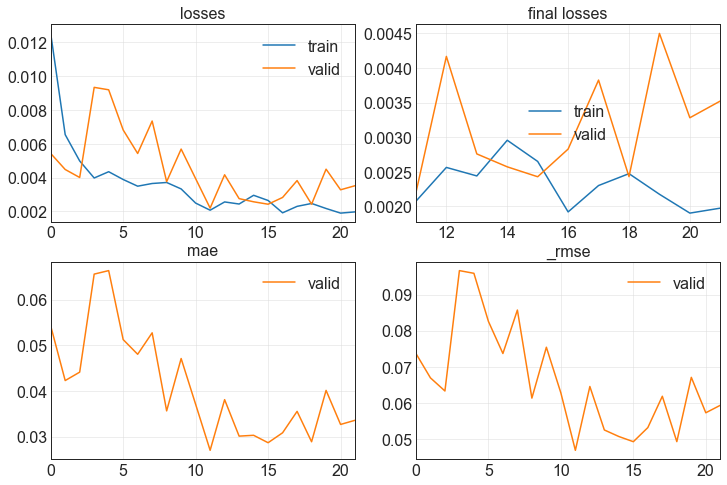

49.04048943519592                                                                                                      
[0.0019743565935641527, 0.003523417515680194, 0.033589377999305725, 0.0593583807349205]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 100, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 63%|███████████████████████████▋                | 63/100 [30:53<20:13, 32.79s/trial, best loss: 0.0021883677691221237]

No improvement since epoch 24: early stopping                                                                          
 63%|███████████████████████████▋                | 63/100 [31:27<20:13, 32.79s/trial, best loss: 0.0021883677691221237]

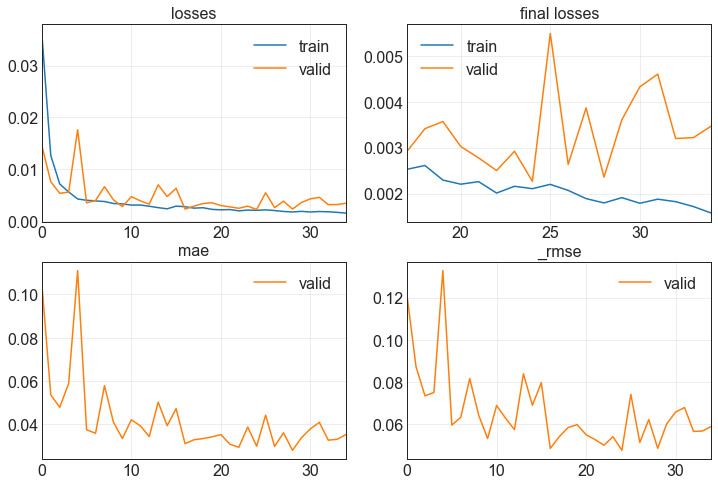

34.30169630050659                                                                                                      
[0.0015731927705928683, 0.003475361270830035, 0.03529348224401474, 0.05895218998193741]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 64%|████████████████████████████▏               | 64/100 [31:28<20:03, 33.42s/trial, best loss: 0.0021883677691221237]

No improvement since epoch 11: early stopping                                                                          
 64%|████████████████████████████▏               | 64/100 [31:53<20:03, 33.42s/trial, best loss: 0.0021883677691221237]

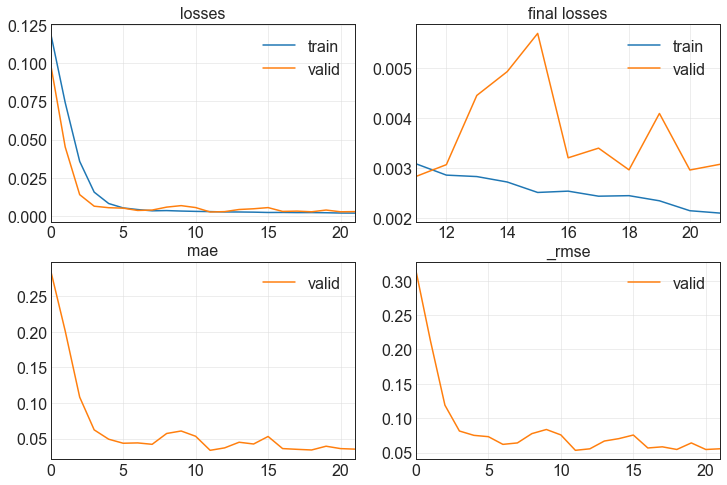

25.364179372787476                                                                                                     
[0.002095557050779462, 0.003072731662541628, 0.035223327577114105, 0.05543222278356552]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 65%|████████████████████████████▌               | 65/100 [31:54<18:12, 31.22s/trial, best loss: 0.0021883677691221237]

No improvement since epoch 32: early stopping                                                                          
 65%|████████████████████████████▌               | 65/100 [32:42<18:12, 31.22s/trial, best loss: 0.0021883677691221237]

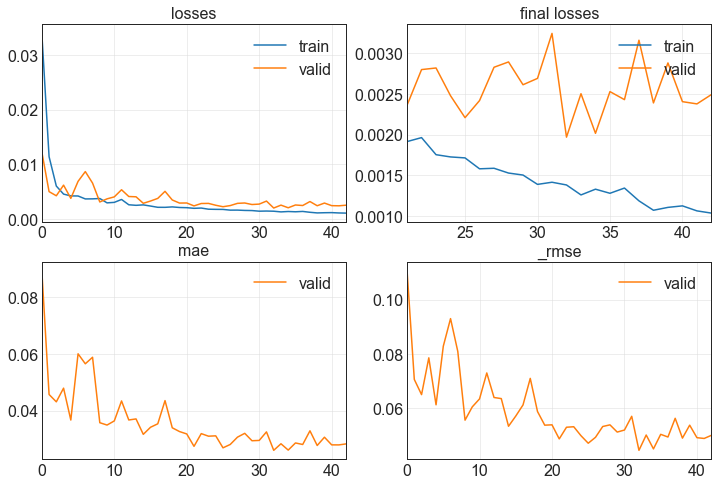

48.361164808273315                                                                                                     
[0.0010364589979872108, 0.0024897633120417595, 0.02823881432414055, 0.04989752918481827]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 66%|█████████████████████████████               | 66/100 [32:43<20:41, 36.53s/trial, best loss: 0.0021883677691221237]

No improvement since epoch 6: early stopping                                                                           
 66%|█████████████████████████████               | 66/100 [33:00<20:41, 36.53s/trial, best loss: 0.0021883677691221237]

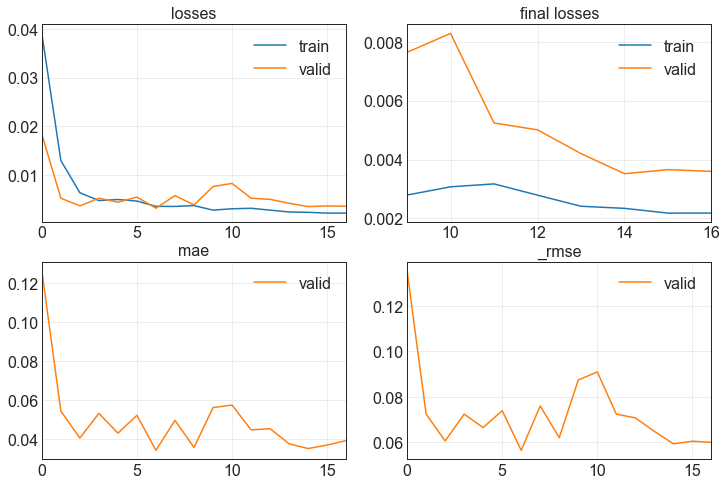

16.968541860580444                                                                                                     
[0.0021838585380464792, 0.0036004772409796715, 0.039264075458049774, 0.06000397726893425]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 67%|█████████████████████████████▍              | 67/100 [33:01<16:57, 30.82s/trial, best loss: 0.0021883677691221237]

No improvement since epoch 29: early stopping                                                                          
 67%|█████████████████████████████▍              | 67/100 [33:46<16:57, 30.82s/trial, best loss: 0.0021883677691221237]

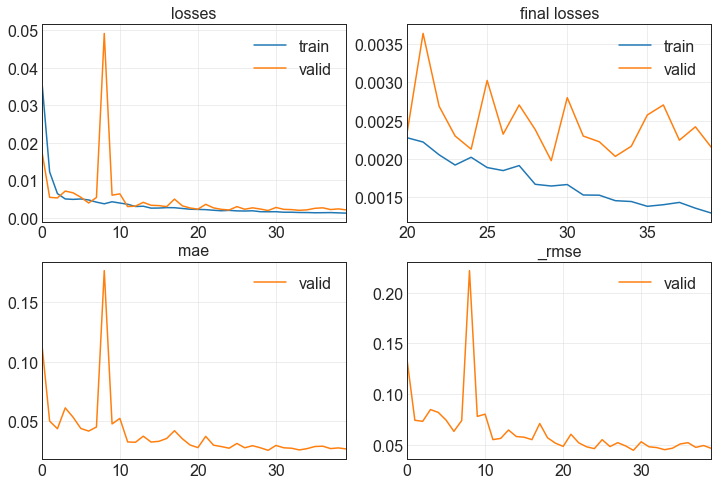

46.114623069763184                                                                                                     
[0.0012957131257280707, 0.00215195887722075, 0.026964114978909492, 0.04638921096920967]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 68%|███████████████████████████████▎              | 68/100 [33:47<18:58, 35.58s/trial, best loss: 0.00215195887722075]

No improvement since epoch 9: early stopping                                                                           
 68%|███████████████████████████████▎              | 68/100 [34:09<18:58, 35.58s/trial, best loss: 0.00215195887722075]

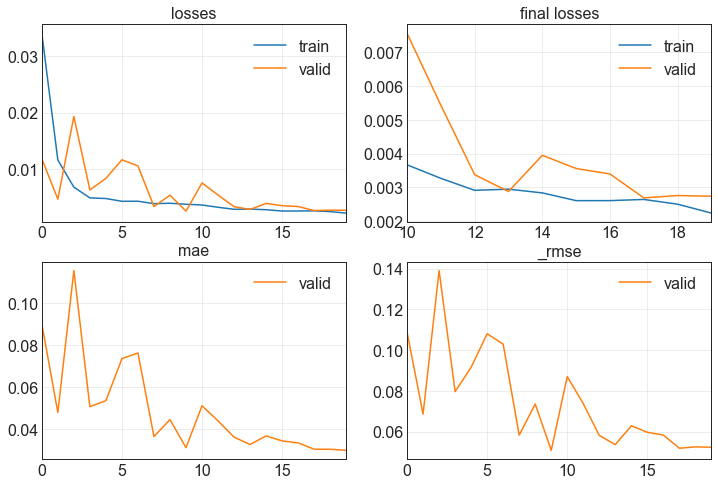

22.427650690078735                                                                                                     
[0.002233529230579734, 0.002734515117481351, 0.029879800975322723, 0.0522925928235054]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 69%|███████████████████████████████▋              | 69/100 [34:10<16:25, 31.80s/trial, best loss: 0.00215195887722075]

No improvement since epoch 24: early stopping                                                                          
 69%|███████████████████████████████▋              | 69/100 [34:49<16:25, 31.80s/trial, best loss: 0.00215195887722075]

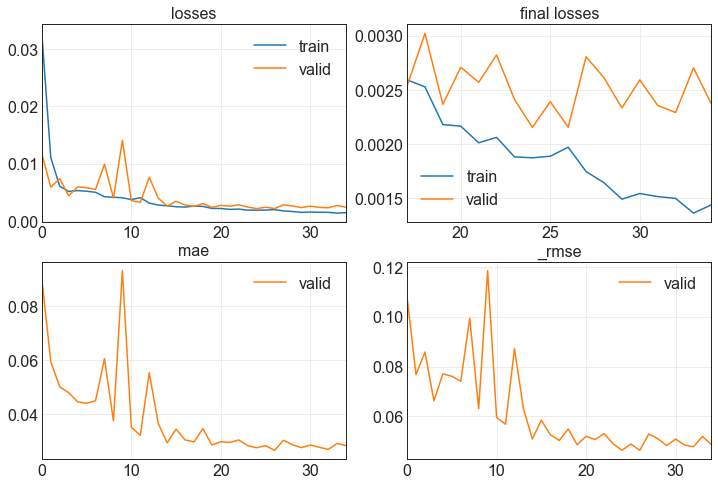

38.868926763534546                                                                                                     
[0.0014394213212653995, 0.0023689069785177708, 0.02843874879181385, 0.0486714132130146]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 70%|████████████████████████████████▏             | 70/100 [34:50<17:02, 34.09s/trial, best loss: 0.00215195887722075]

No improvement since epoch 37: early stopping                                                                          
 70%|████████████████████████████████▏             | 70/100 [35:44<17:02, 34.09s/trial, best loss: 0.00215195887722075]

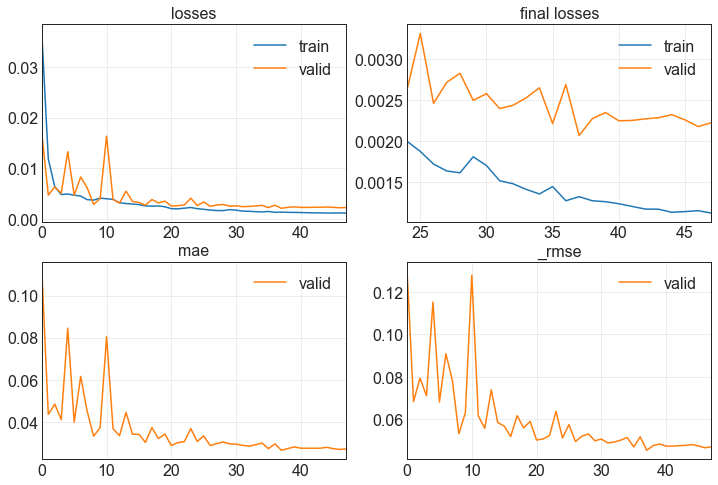

54.49465990066528                                                                                                      
[0.0011234275298193097, 0.0022280681878328323, 0.027123719453811646, 0.04720241576433182]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 71%|████████████████████████████████▋             | 71/100 [35:45<19:30, 40.38s/trial, best loss: 0.00215195887722075]

No improvement since epoch 2: early stopping                                                                           
 71%|████████████████████████████████▋             | 71/100 [36:00<19:30, 40.38s/trial, best loss: 0.00215195887722075]

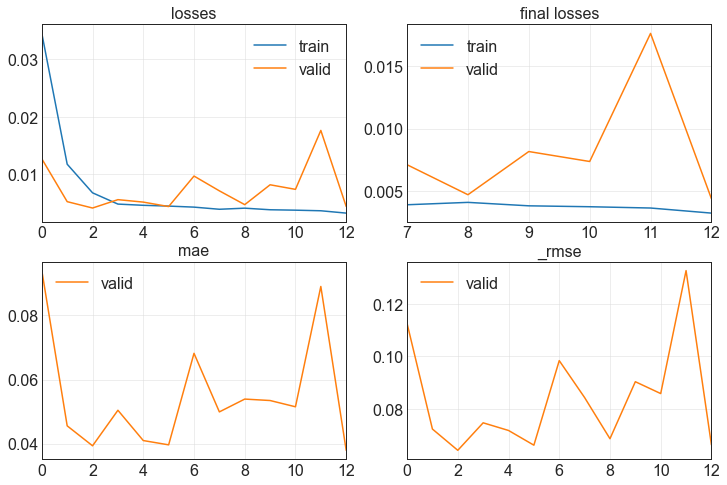

15.447595596313477                                                                                                     
[0.003230639500543475, 0.004386594519019127, 0.037926554679870605, 0.066231369972229]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 72%|█████████████████████████████████             | 72/100 [36:01<15:25, 33.06s/trial, best loss: 0.00215195887722075]

No improvement since epoch 31: early stopping                                                                          
 72%|█████████████████████████████████             | 72/100 [36:15<15:25, 33.06s/trial, best loss: 0.00215195887722075]

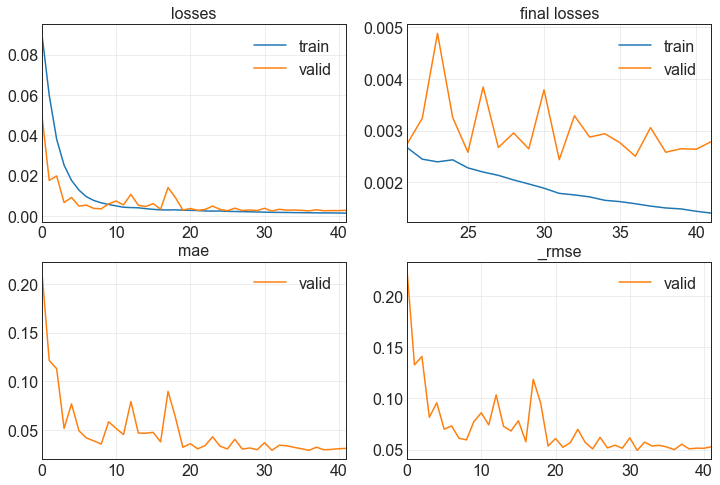

14.36899471282959                                                                                                      
[0.0014015388442203403, 0.0027892806101590395, 0.03107103891670704, 0.05281364172697067]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 73%|█████████████████████████████████▌            | 73/100 [36:16<12:25, 27.63s/trial, best loss: 0.00215195887722075]

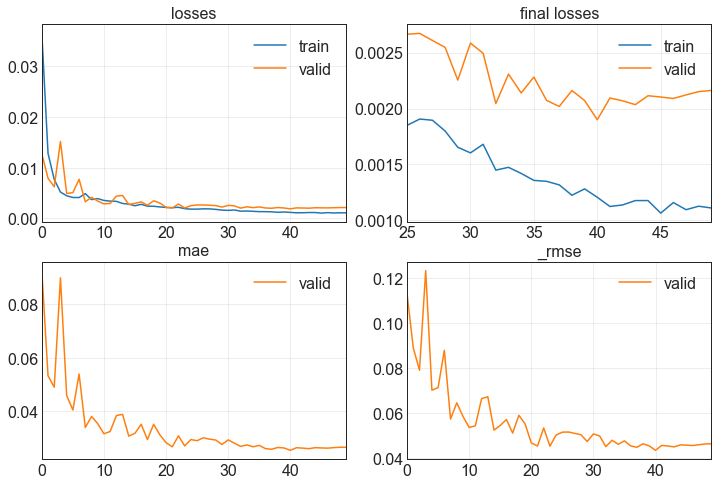

57.039494037628174                                                                                                     
[0.0011088767787441611, 0.0021620807237923145, 0.02662387676537037, 0.04649817571043968]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 74%|██████████████████████████████████            | 74/100 [37:13<15:52, 36.62s/trial, best loss: 0.00215195887722075]

No improvement since epoch 25: early stopping                                                                          
 74%|██████████████████████████████████            | 74/100 [38:06<15:52, 36.62s/trial, best loss: 0.00215195887722075]

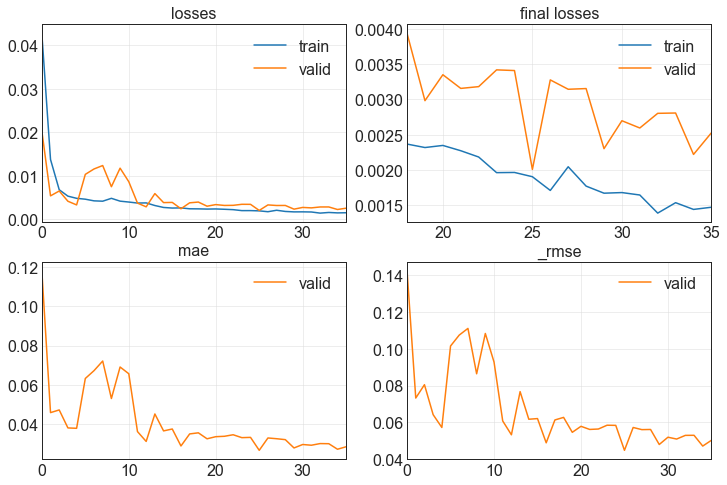

52.97383403778076                                                                                                      
[0.001473353593610227, 0.002527437871322036, 0.028451021760702133, 0.050273630768060684]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 75%|██████████████████████████████████▌           | 75/100 [38:07<17:22, 41.69s/trial, best loss: 0.00215195887722075]

No improvement since epoch 27: early stopping                                                                          
 75%|██████████████████████████████████▌           | 75/100 [39:34<17:22, 41.69s/trial, best loss: 0.00215195887722075]

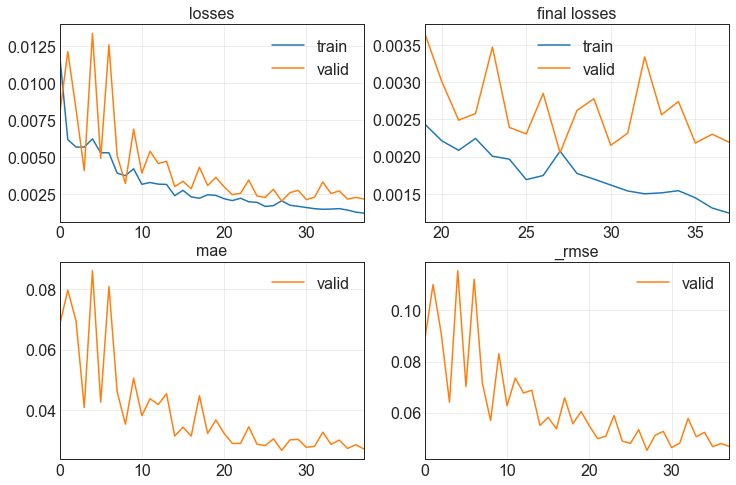

87.77203273773193                                                                                                      
[0.0012421952560544014, 0.0021928308997303247, 0.026944510638713837, 0.04682767391204834]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 76%|██████████████████████████████████▉           | 76/100 [39:35<22:16, 55.68s/trial, best loss: 0.00215195887722075]

No improvement since epoch 16: early stopping                                                                          
 76%|██████████████████████████████████▉           | 76/100 [40:10<22:16, 55.68s/trial, best loss: 0.00215195887722075]

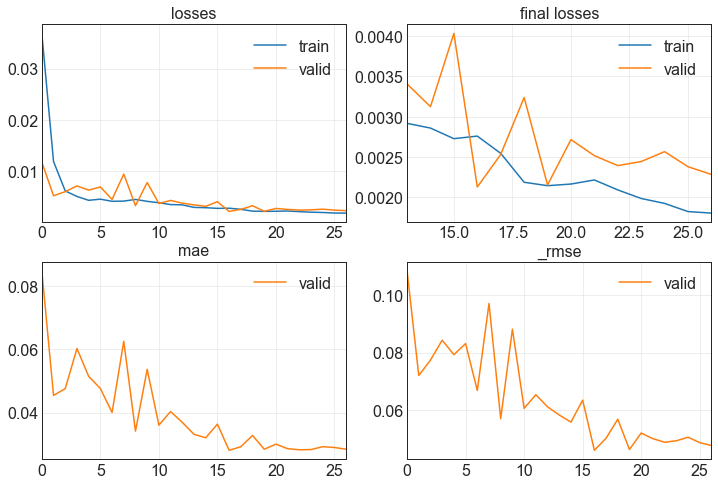

34.94795823097229                                                                                                      
[0.001804855652153492, 0.0022841941099613905, 0.02843303792178631, 0.04779324308037758]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.5, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 77%|███████████████████████████████████▍          | 77/100 [40:11<19:01, 49.63s/trial, best loss: 0.00215195887722075]

No improvement since epoch 6: early stopping                                                                           
 77%|███████████████████████████████████▍          | 77/100 [40:29<19:01, 49.63s/trial, best loss: 0.00215195887722075]

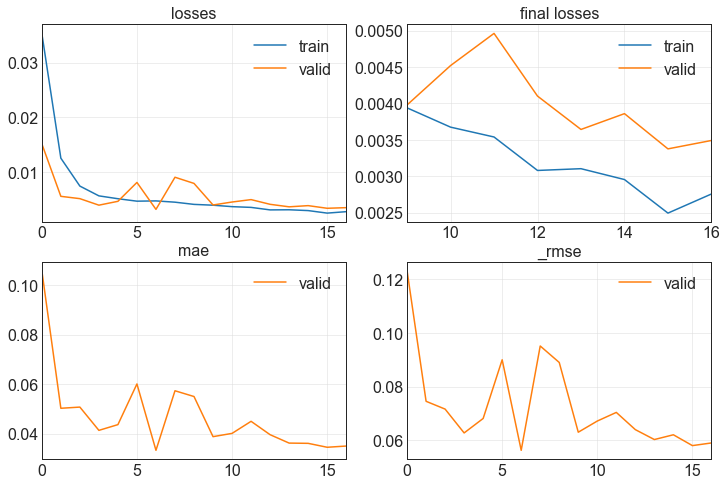

19.026581287384033                                                                                                     
[0.0027545595075935125, 0.0034899970050901175, 0.03495614603161812, 0.05907619372010231]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 78%|███████████████████████████████████▉          | 78/100 [40:30<14:53, 40.62s/trial, best loss: 0.00215195887722075]

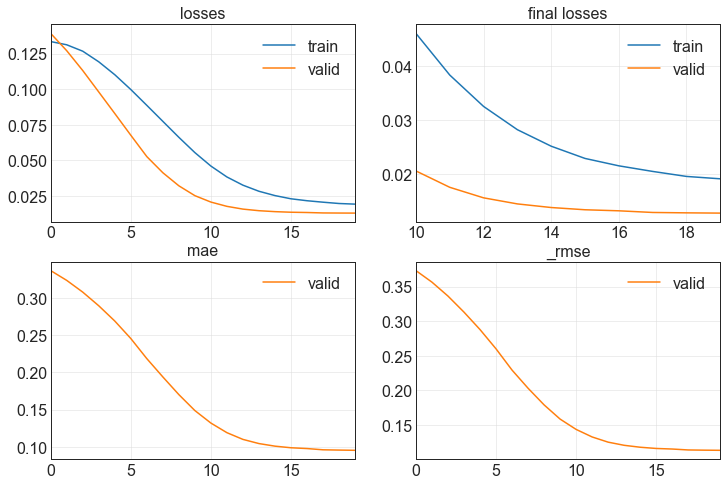

6.51279354095459                                                                                                       
[0.019184065982699394, 0.012867668643593788, 0.09518896788358688, 0.11343573778867722]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.8, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 79%|████████████████████████████████████▎         | 79/100 [40:37<10:41, 30.55s/trial, best loss: 0.00215195887722075]

No improvement since epoch 10: early stopping                                                                          
 79%|████████████████████████████████████▎         | 79/100 [40:50<10:41, 30.55s/trial, best loss: 0.00215195887722075]

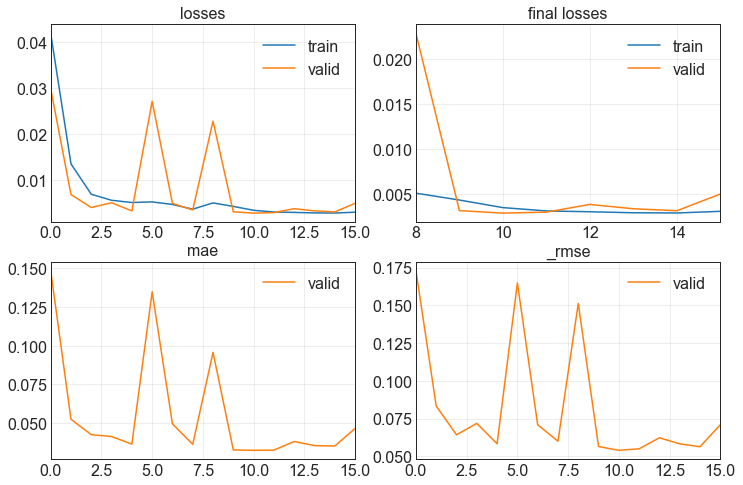

13.490657091140747                                                                                                     
[0.0031118090264499187, 0.005029389634728432, 0.04650115594267845, 0.07091818749904633]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 100, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 80%|████████████████████████████████████▊         | 80/100 [40:51<08:31, 25.59s/trial, best loss: 0.00215195887722075]

No improvement since epoch 39: early stopping                                                                          
 80%|████████████████████████████████████▊         | 80/100 [41:46<08:31, 25.59s/trial, best loss: 0.00215195887722075]

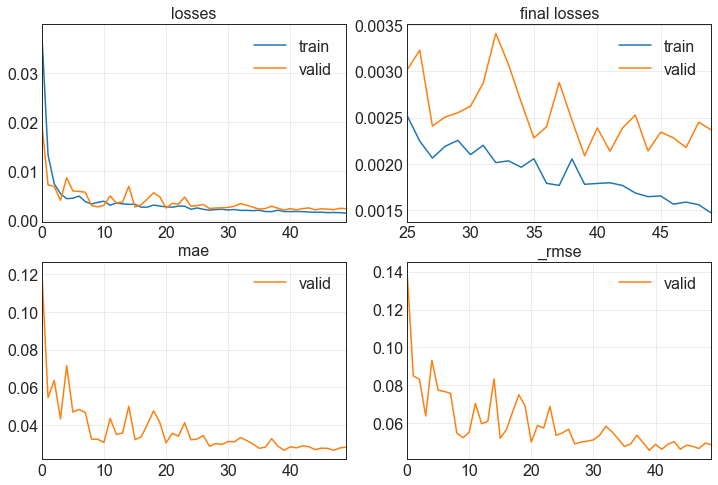

55.3793420791626                                                                                                       
[0.001467628520913422, 0.002366684377193451, 0.028431514278054237, 0.04864858090877533]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 81%|█████████████████████████████████████▎        | 81/100 [41:47<10:59, 34.70s/trial, best loss: 0.00215195887722075]

No improvement since epoch 32: early stopping                                                                          
 81%|█████████████████████████████████████▎        | 81/100 [42:21<10:59, 34.70s/trial, best loss: 0.00215195887722075]

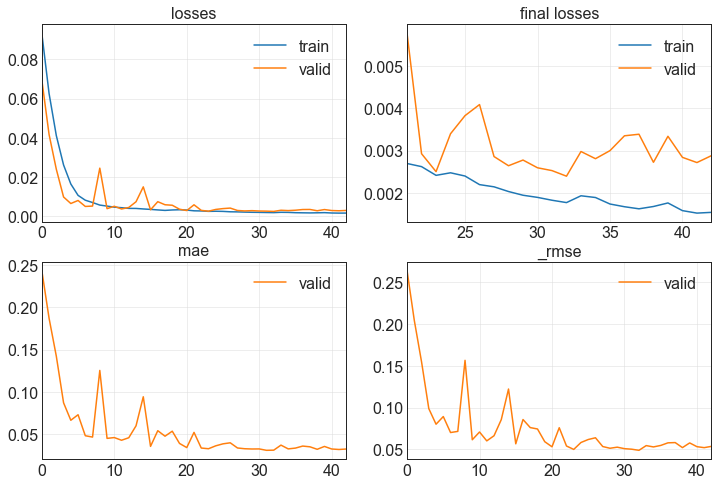

34.560025453567505                                                                                                     
[0.00154149963054806, 0.002881158608943224, 0.03218038007616997, 0.05367642641067505]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.5, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 82%|█████████████████████████████████████▋        | 82/100 [42:22<10:26, 34.83s/trial, best loss: 0.00215195887722075]

No improvement since epoch 11: early stopping                                                                          
 82%|█████████████████████████████████████▋        | 82/100 [43:09<10:26, 34.83s/trial, best loss: 0.00215195887722075]

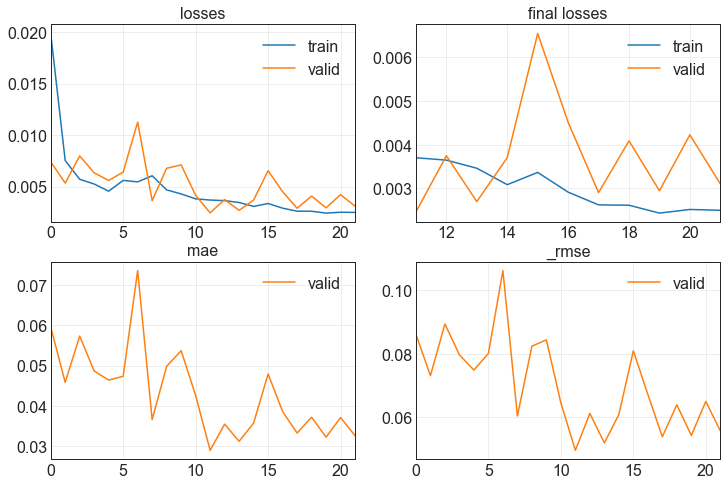

47.1358528137207                                                                                                       
[0.002500915201380849, 0.0031066795345395803, 0.03259562700986862, 0.05573759227991104]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 83%|██████████████████████████████████████▏       | 83/100 [43:10<10:57, 38.69s/trial, best loss: 0.00215195887722075]

No improvement since epoch 19: early stopping                                                                          
 83%|██████████████████████████████████████▏       | 83/100 [43:48<10:57, 38.69s/trial, best loss: 0.00215195887722075]

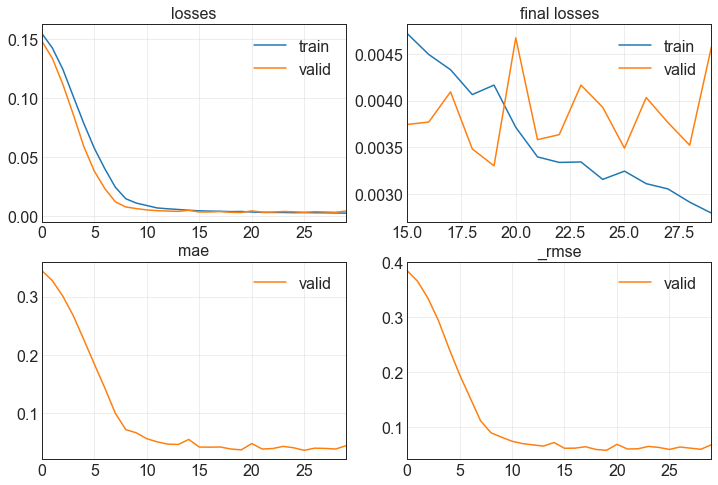

38.81482148170471                                                                                                      
[0.002797742374241352, 0.004574359394609928, 0.0445089228451252, 0.06763401627540588]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.3, 'hidden_size': 100, 'kss': (5, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 84%|██████████████████████████████████████▋       | 84/100 [43:49<10:22, 38.89s/trial, best loss: 0.00215195887722075]

No improvement since epoch 14: early stopping                                                                          
 84%|██████████████████████████████████████▋       | 84/100 [44:07<10:22, 38.89s/trial, best loss: 0.00215195887722075]

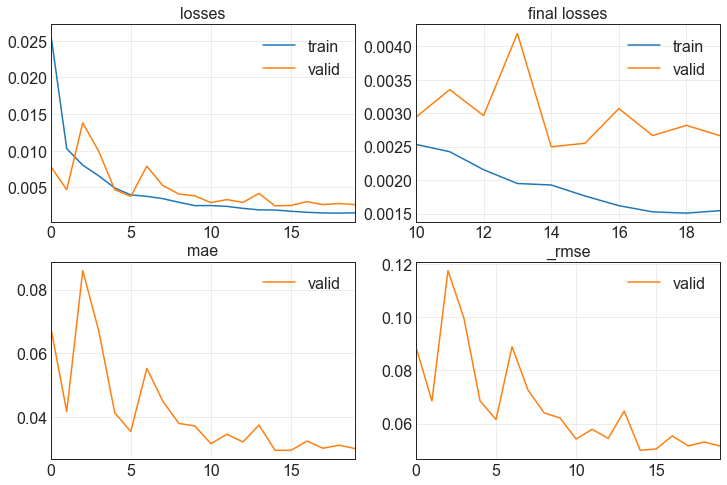

17.94817876815796                                                                                                      
[0.001543488004244864, 0.0026622451841831207, 0.030120931565761566, 0.051596950739622116]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 100, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 85%|███████████████████████████████████████       | 85/100 [44:08<08:11, 32.77s/trial, best loss: 0.00215195887722075]

No improvement since epoch 5: early stopping                                                                           
 85%|███████████████████████████████████████       | 85/100 [44:25<08:11, 32.77s/trial, best loss: 0.00215195887722075]

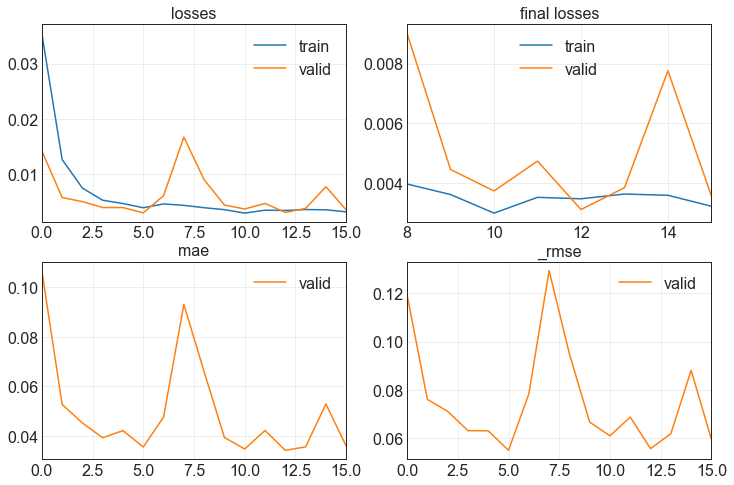

17.86730170249939                                                                                                      
[0.0032200198620557785, 0.003559200558811426, 0.035947900265455246, 0.05965903401374817]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.5, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 86%|███████████████████████████████████████▌      | 86/100 [44:26<06:38, 28.47s/trial, best loss: 0.00215195887722075]

No improvement since epoch 29: early stopping                                                                          
 86%|███████████████████████████████████████▌      | 86/100 [44:45<06:38, 28.47s/trial, best loss: 0.00215195887722075]

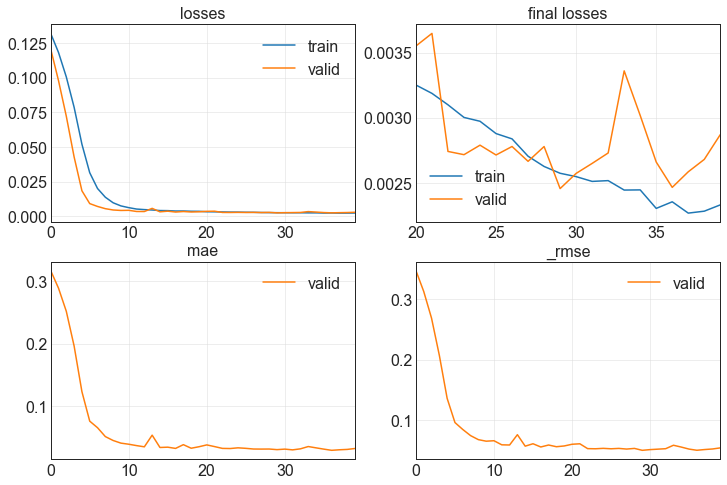

19.158411979675293                                                                                                     
[0.0023306154180318117, 0.0028700081165879965, 0.03294292464852333, 0.053572461009025574]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 87%|████████████████████████████████████████      | 87/100 [44:46<05:35, 25.84s/trial, best loss: 0.00215195887722075]

No improvement since epoch 35: early stopping                                                                          
 87%|████████████████████████████████████████      | 87/100 [45:01<05:35, 25.84s/trial, best loss: 0.00215195887722075]

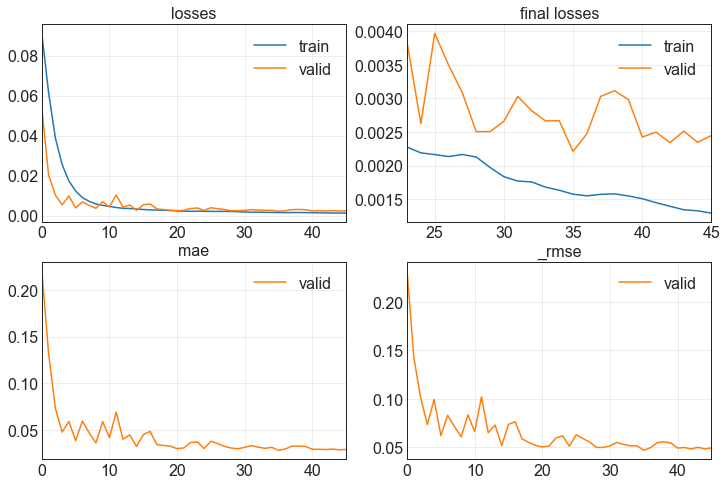

15.050941944122314                                                                                                     
[0.0012920282315462828, 0.0024474174715578556, 0.02905827760696411, 0.049471382051706314]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 100, 'kss': (5, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.8, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 88%|████████████████████████████████████████▍     | 88/100 [45:02<04:33, 22.77s/trial, best loss: 0.00215195887722075]

No improvement since epoch 18: early stopping                                                                          
 88%|████████████████████████████████████████▍     | 88/100 [45:28<04:33, 22.77s/trial, best loss: 0.00215195887722075]

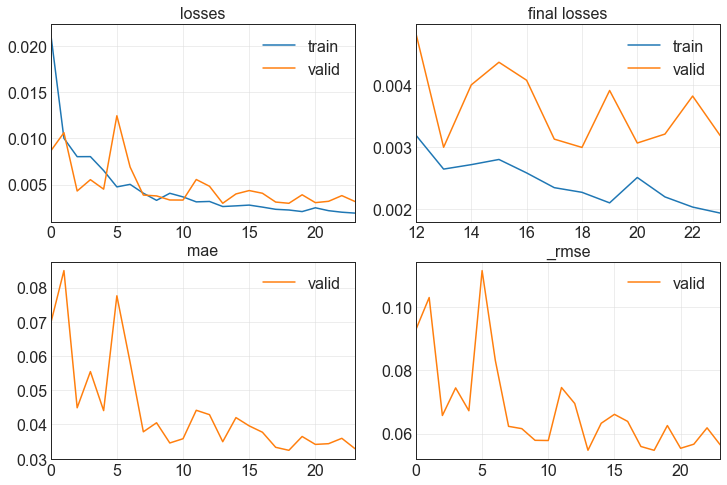

26.288391828536987                                                                                                     
[0.0019325403263792396, 0.0031816111877560616, 0.032915178686380386, 0.056405775249004364]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 89%|████████████████████████████████████████▉     | 89/100 [45:28<04:23, 23.99s/trial, best loss: 0.00215195887722075]

No improvement since epoch 23: early stopping                                                                          
 89%|████████████████████████████████████████▉     | 89/100 [46:55<04:23, 23.99s/trial, best loss: 0.00215195887722075]

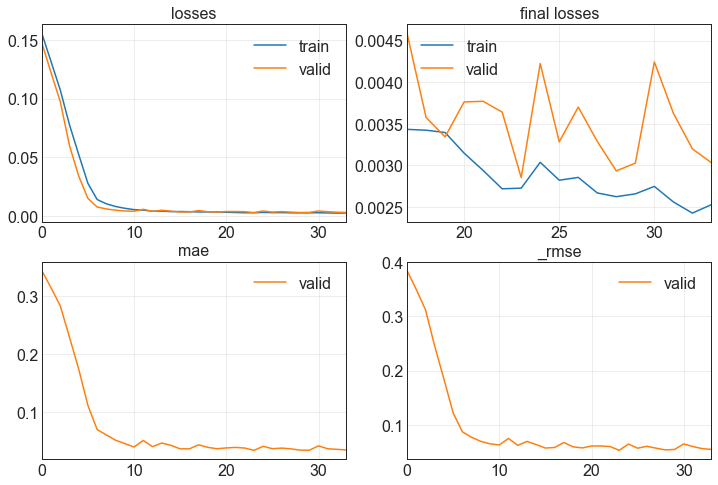

87.0612416267395                                                                                                       
[0.0025260623078793287, 0.0030309392604976892, 0.03535497933626175, 0.05505397170782089]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.5, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 90%|█████████████████████████████████████████▍    | 90/100 [46:56<07:10, 43.08s/trial, best loss: 0.00215195887722075]

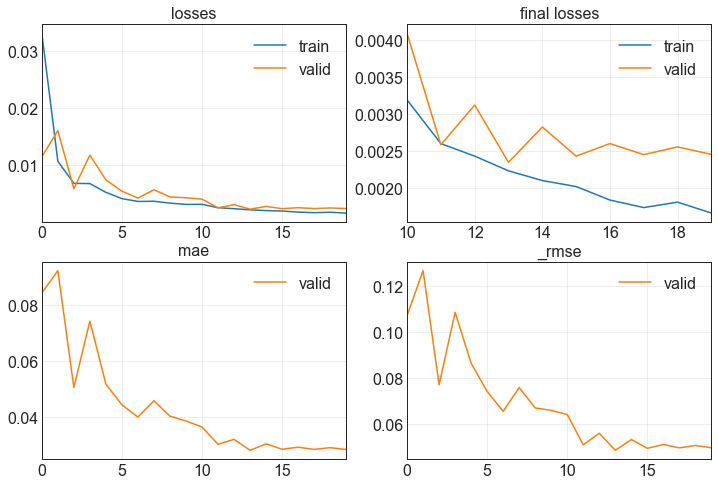

23.211241960525513                                                                                                     
[0.0016568558057770133, 0.0024529744405299425, 0.028619734570384026, 0.04952751100063324]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 100, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 91%|█████████████████████████████████████████▊    | 91/100 [47:20<05:35, 37.30s/trial, best loss: 0.00215195887722075]

No improvement since epoch 27: early stopping                                                                          
 91%|█████████████████████████████████████████▊    | 91/100 [48:04<05:35, 37.30s/trial, best loss: 0.00215195887722075]

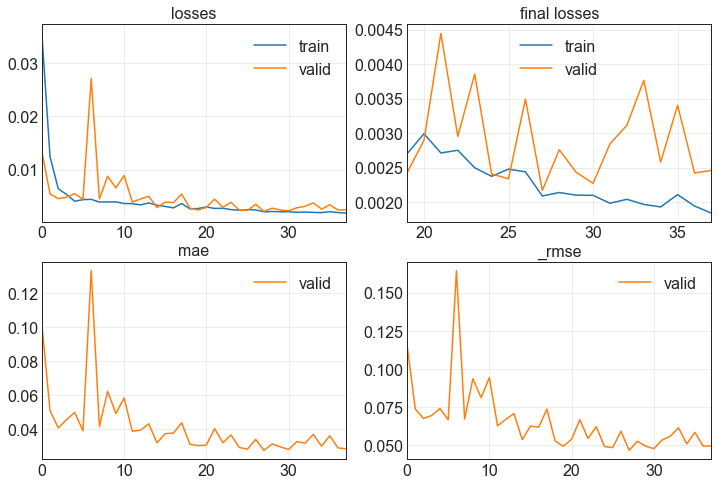

44.23683977127075                                                                                                      
[0.0018400853732600808, 0.002457844791933894, 0.028226148337125778, 0.049576662480831146]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 100, 'kss': (5, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 92%|██████████████████████████████████████████▎   | 92/100 [48:05<05:16, 39.55s/trial, best loss: 0.00215195887722075]

No improvement since epoch 30: early stopping                                                                          
 92%|██████████████████████████████████████████▎   | 92/100 [48:25<05:16, 39.55s/trial, best loss: 0.00215195887722075]

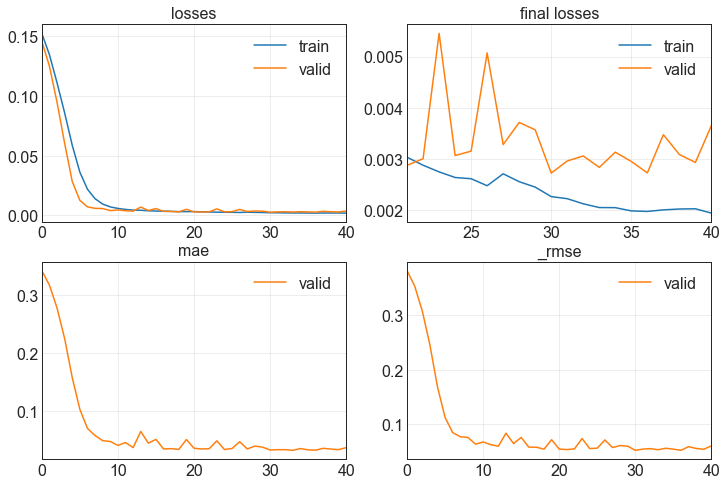

20.47801446914673                                                                                                      
[0.0019440061878412962, 0.0036554757971316576, 0.0362691730260849, 0.06046053394675255]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 93%|██████████████████████████████████████████▊   | 93/100 [48:26<03:58, 34.00s/trial, best loss: 0.00215195887722075]

No improvement since epoch 17: early stopping                                                                          
 93%|██████████████████████████████████████████▊   | 93/100 [48:32<03:58, 34.00s/trial, best loss: 0.00215195887722075]

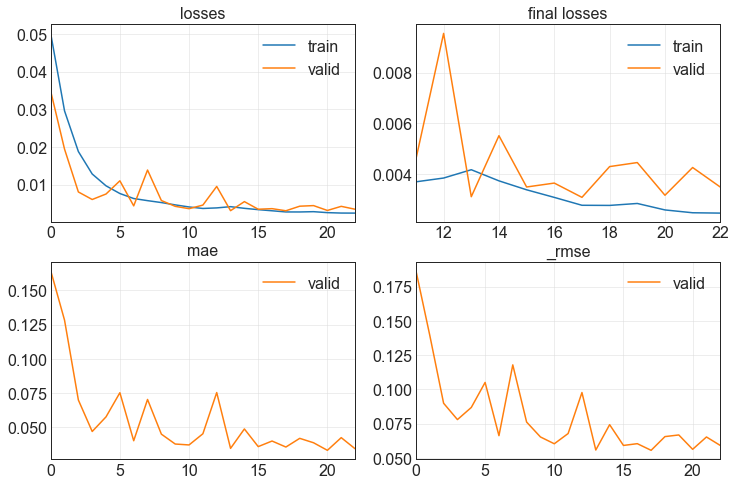

6.709829330444336                                                                                                      
[0.0024636255111545324, 0.0034900519531220198, 0.034441154450178146, 0.059076663106679916]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 94%|███████████████████████████████████████████▏  | 94/100 [48:33<02:35, 25.98s/trial, best loss: 0.00215195887722075]

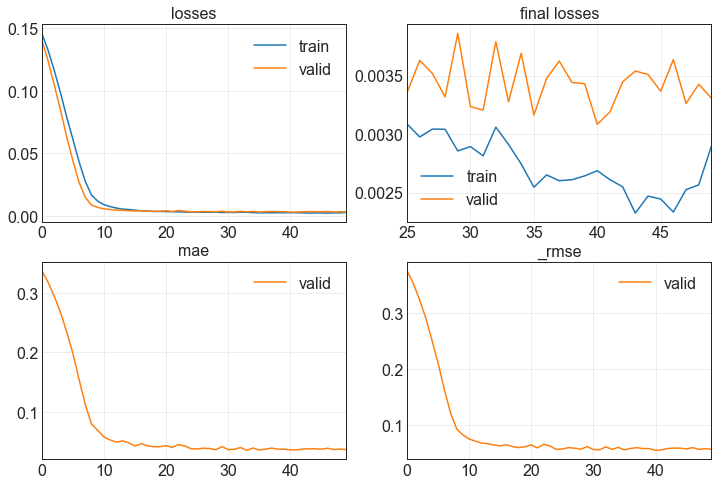

55.350412130355835                                                                                                     
[0.002898391569033265, 0.003306507132947445, 0.036358922719955444, 0.05750223621726036]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 20, 'fc_dropout': 0.5, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 4}
LSTM_FCN                                                                                                               
 95%|███████████████████████████████████████████▋  | 95/100 [49:29<02:54, 34.96s/trial, best loss: 0.00215195887722075]

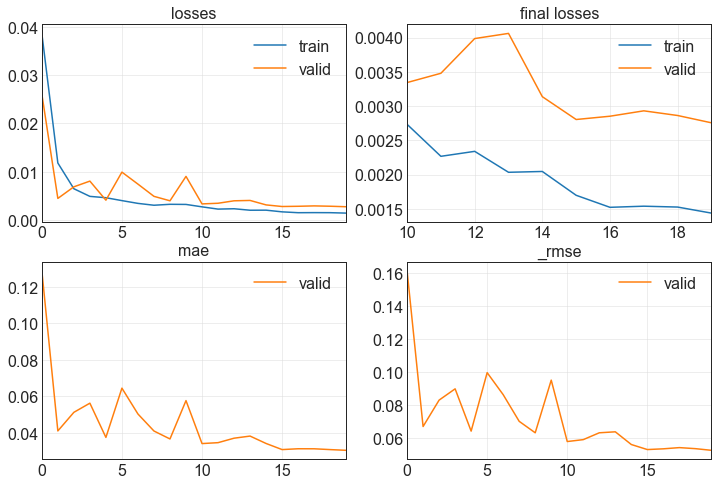

29.121927738189697                                                                                                     
[0.001436581020243466, 0.002754857065156102, 0.030447328463196754, 0.052486732602119446]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.0, 'hidden_size': 200, 'kss': (5, 5, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 3}
LSTM_FCN                                                                                                               
 96%|████████████████████████████████████████████▏ | 96/100 [49:59<02:13, 33.38s/trial, best loss: 0.00215195887722075]

No improvement since epoch 14: early stopping                                                                          
 96%|████████████████████████████████████████████▏ | 96/100 [51:03<02:13, 33.38s/trial, best loss: 0.00215195887722075]

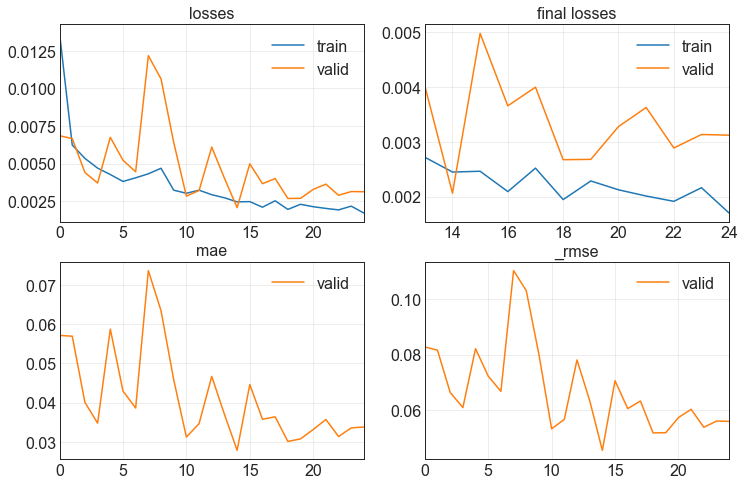

64.80650663375854                                                                                                      
[0.0016976273618638515, 0.0031211881432682276, 0.03381213918328285, 0.055867597460746765]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 100, 'fc_dropout': 0.3, 'hidden_size': 100, 'kss': (3, 3, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 5, 'rnn_dropout': 0.3, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 97%|████████████████████████████████████████████▌ | 97/100 [51:04<02:08, 42.97s/trial, best loss: 0.00215195887722075]

No improvement since epoch 10: early stopping                                                                          
 97%|████████████████████████████████████████████▌ | 97/100 [51:21<02:08, 42.97s/trial, best loss: 0.00215195887722075]

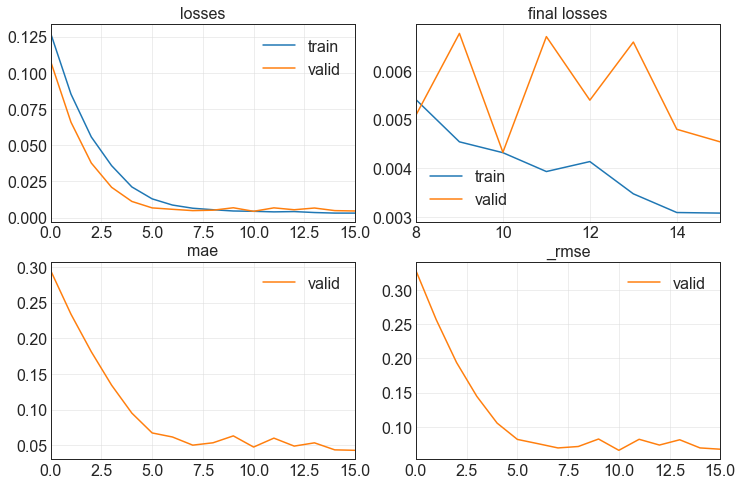

17.107665538787842                                                                                                     
[0.003075461136177182, 0.004538412671536207, 0.04285548999905586, 0.06736773997545242]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}
LSTM_FCN                                                                                                               
 98%|█████████████████████████████████████████████ | 98/100 [51:22<01:10, 35.38s/trial, best loss: 0.00215195887722075]

No improvement since epoch 13: early stopping                                                                          
 98%|█████████████████████████████████████████████ | 98/100 [51:43<01:10, 35.38s/trial, best loss: 0.00215195887722075]

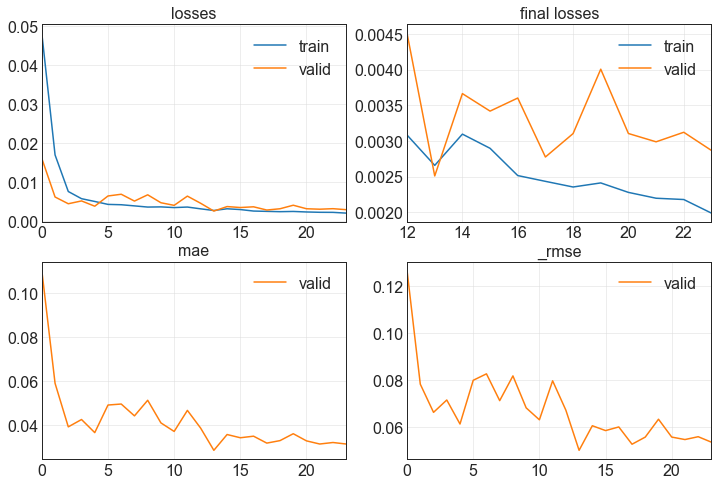

22.16853427886963                                                                                                      
[0.0019871683325618505, 0.00286673242226243, 0.03159869462251663, 0.0535418726503849]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.3, 'rnn_layers': 1}
LSTM_FCN                                                                                                               
 99%|█████████████████████████████████████████████▌| 99/100 [51:44<00:31, 31.59s/trial, best loss: 0.00215195887722075]

No improvement since epoch 18: early stopping                                                                          
 99%|█████████████████████████████████████████████▌| 99/100 [51:59<00:31, 31.59s/trial, best loss: 0.00215195887722075]

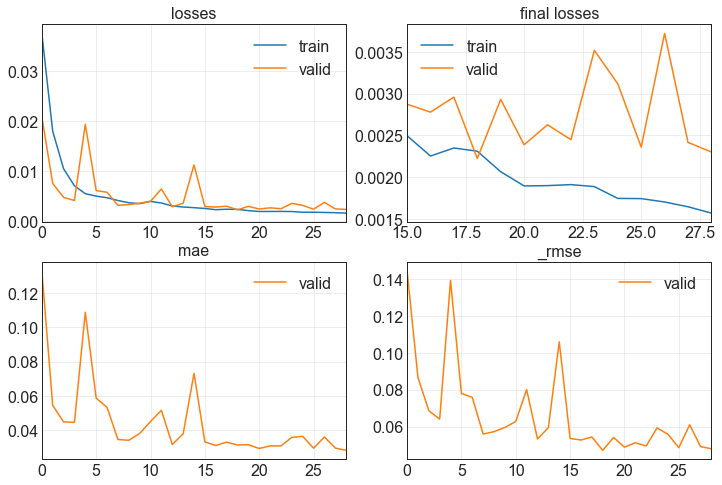

14.807748556137085                                                                                                     
[0.0015696292975917459, 0.002300866646692157, 0.02821222133934498, 0.047967348247766495]                               
100%|█████████████████████████████████████████████| 100/100 [51:59<00:00, 31.20s/trial, best loss: 0.00215195887722075]


In [59]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [60]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 32, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'fc_dropout': 0.3, 'hidden_size': 200, 'kss': (3, 3, 3), 'lr': 0.01, 'optimizer': <function Adam at 0x0000017F1C9F6048>, 'patience': 10, 'rnn_dropout': 0.8, 'rnn_layers': 2}


In [61]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [62]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [63]:
batch_size = params["batch_size"]
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [64]:
arch = LSTM_FCN
k = {
    'rnn_layers': params['rnn_layers'],
    'hidden_size': params['hidden_size'],
    'bidirectional': params['bidirectional'],
    'rnn_dropout': params['rnn_dropout'],
    'conv_layers': params['conv_layers'],
    'kss': params['kss'],
    'fc_dropout': params['fc_dropout']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())
model

LSTM_FCN


Sequential(
  (0): LSTM_FCN(
    (rnn): LSTM(24, 200, num_layers=2, batch_first=True, bidirectional=True)
    (rnn_dropout): Dropout(p=0.8, inplace=False)
    (convblock1): ConvBlock(
      (0): Conv1d(3, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock2): ConvBlock(
      (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock3): ConvBlock(
      (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (gap): GAP1d(
      (gap): AdaptiveAvgPool1d(output_size=1)
      (flatten): Flatten(full=False)
    )
    (concat): Concat(dim=1)
    (fc_dropout): Drop

Training the model:

No improvement since epoch 23: early stopping


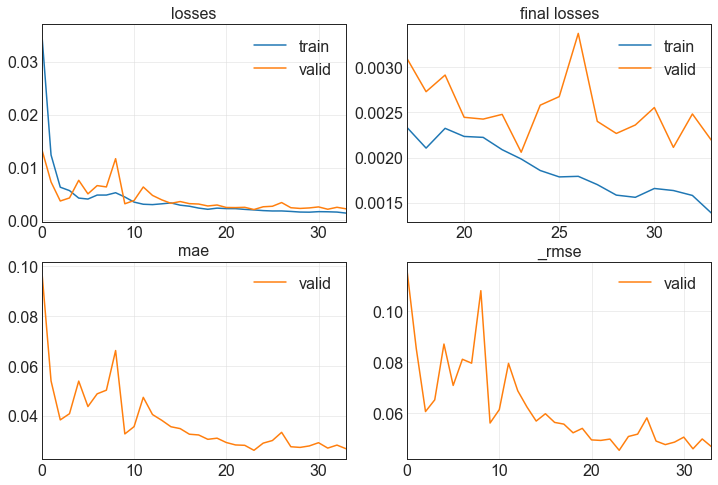

In [65]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [66]:
dls = learn.dls
valid_dl = dls.valid

test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

708


In [67]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0122],
         [0.0305],
         [0.0097],
         [0.0091],
         [0.0068],
         [0.0036],
         [0.0057],
         [0.0050],
         [0.0107],
         [0.0245],
         [0.1569],
         [0.0218],
         [0.0150],
         [0.0162],
         [0.0205],
         [0.0134],
         [0.0169],
         [0.0155],
         [0.0113],
         [0.0102],
         [0.0122],
         [0.0242],
         [0.0151],
         [0.0101],
         [0.0118],
         [0.0102],
         [0.0114],
         [0.0091],
         [0.0104],
         [0.0070],
         [0.0121],
         [0.0134],
         [0.0145],
         [0.0379],
         [0.3833],
         [0.6751],
         [0.6378],
         [0.6335],
         [0.6196],
         [0.5829],
         [0.7208],
         [0.6131],
         [0.5404],
         [0.3932],
         [0.2547],
         [0.0783],
         [0.0428],
         [0.0309],
         [0.0121],
         [0.0061],
         [0.0058],
         [0.0167],
         [0.

In [68]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [69]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

Transform the data in the normal range:

In [70]:
def inverse_normalization(prediction, y, max_list, min_list):
    # we only use the max and min for value_avg
    max_value = max_list[0]
    min_value = min_list[0]
    inverse_prediction = prediction * (max_value - min_value) + min_value
    inverse_y = y * (max_value - min_value) + min_value

    return inverse_prediction, inverse_y

In [71]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, 0], y_true[i, step, 0], max_list, min_list)
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [72]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [73]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [74]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  38.667165756225586
Test time (in seconds):  0.14100170135498047


In [23]:
print('Training time (in seconds) per epoch: ', 38.667165756225586 / 34)

Training time (in seconds) per epoch:  1.1372695810654585


Define the evaluation metrics:

In [75]:
def check_error(orig, pred, name_col='', index_name=''):
    
    bias = np.mean(orig - pred)
    mse = mean_squared_error(orig, pred)
    rmse = sqrt(mean_squared_error(orig, pred))
    mae = mean_absolute_error(orig, pred)
    mape = np.mean(np.abs((orig - pred) / orig)) * 100
    
    error_group = [bias, mse, rmse, mae, mape]
    result = pd.DataFrame(error_group, index=['BIAS','MSE','RMSE','MAE', 'MAPE'], columns=[name_col])
    result.index.name = index_name
    
    return result

We evaluate the prediction in the next step:

In [76]:
step_to_evalute = 0
true_values = y_true[:, step_to_evalute]
pred_values = y_pred[:, step_to_evalute]

In [77]:
result = pd.DataFrame()

In [78]:
check_error(true_values, pred_values, name_col=model_name)

LSTM_FCN
                  
BIAS  2.195276e+06
MSE   1.597786e+14
RMSE  1.264035e+07
MAE   7.458732e+06
MAPE  4.177856e+01

We would also analyze the characteristics of the residual itself, as there are cases where the model can not capture the information necessary to make a good forecast resulting in a error with information that should be used to improve the forecast.

To verify this residual we will check:

* Actual vs. predicted values (sequential chart);

* Residual vs. predicted values (dispersion chart):
    + It is very important to analyze this graph, since in it we can check patterns that can tell us if some modification is needed in the model, the ideal is that the error is distributed linearly along the forecast sequence.

* QQ plot of the residual (dispersion chart):
    + Summarizing this is a graph that shows where the residue should be theoretically distributed, following a Gaussian distribution, versus how it actually is.

* Residual autocorrelation (sequential chart):
    + Where there should be no values that come out of the confidence margin, or the model is leaving information out of the model.

In [79]:
def plot_error(data, figsize=(12, 9), lags=24, rotation=0):
    
    # Creating the column error
    data['Error'] = data.iloc[:,0] - data.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    # Plotting actual and predicted values
    ax1.plot(data.iloc[:, 0:2])
    ax1.legend(['Real', 'Pred'])
    ax1.set_title('Real Value vs Prediction')
    ax1.xaxis.set_tick_params(rotation=rotation)
    
    # Error vs Predicted value
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residual')
    ax2.set_title('Residual vs Predicted Values')
    
    # Residual QQ Plot
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation Plot of residual
    plot_acf(data.iloc[:, 2], lags=lags, zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

Now we evaluate on the test set:

In [80]:
target = 'value_avg'

model_test = test[[target]].copy()
model_test.index = test.index
model_test.columns = ['Real']

model_test['Pred'] = pred_values

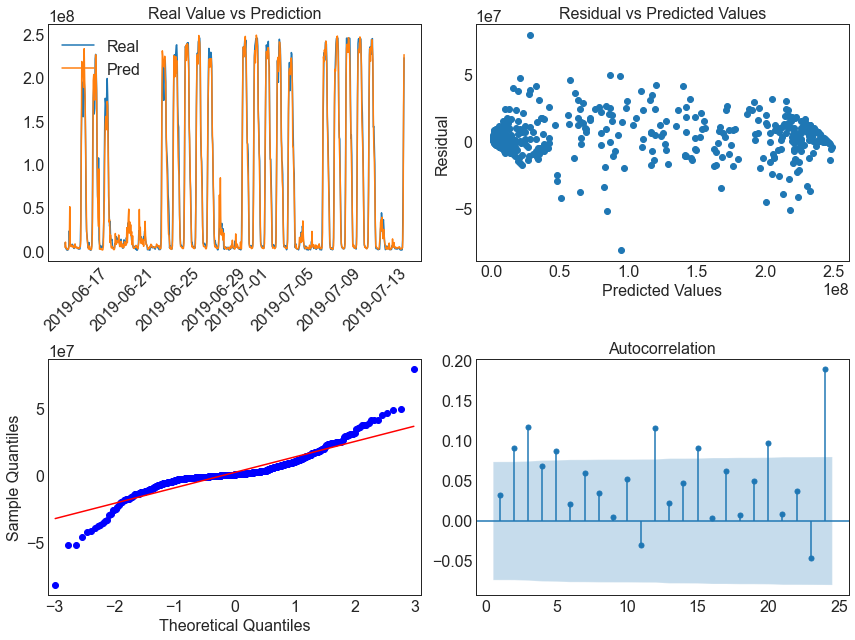

In [81]:
plot_error(model_test, rotation=45)